In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_preds = pd.read_csv("../preds/train_preds_deepant.csv", parse_dates=["date"])
preds = pd.read_csv("../preds/preds_deepant.csv", parse_dates=["date"])
preds["set"] = preds.ts_id.str.split("_", expand=True)[1]

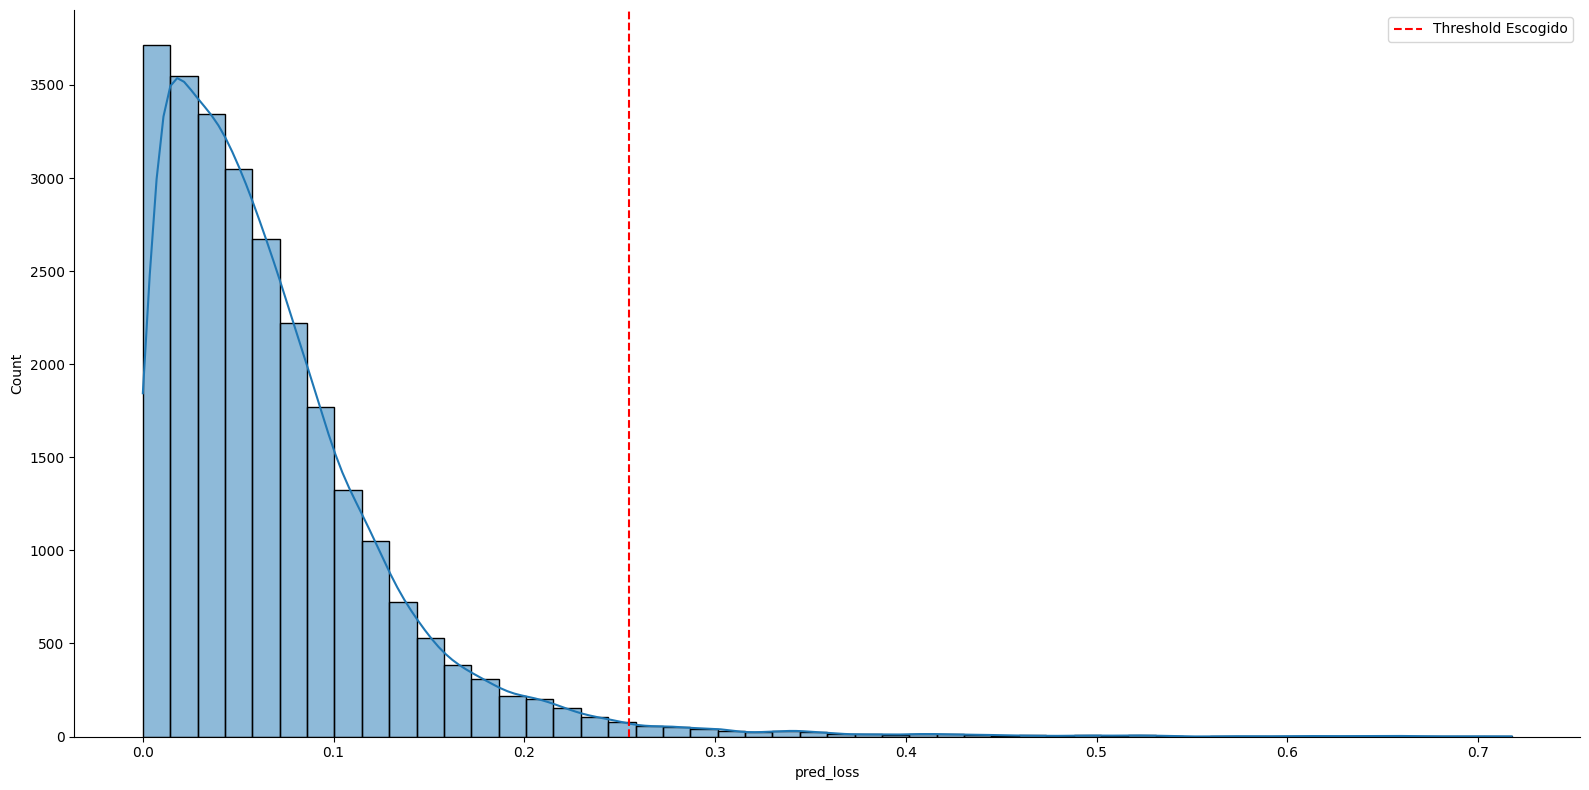

In [23]:
mu = train_preds.pred_loss.mean()
sd = train_preds.pred_loss.std()
sns.displot(x = "pred_loss", data = train_preds, bins = 50, kde = True, height = 8, aspect = 2)
plt.axvline(x = mu + 3*sd, color = "r", linestyle = "--", label = "Threshold Escogido")
plt.legend();


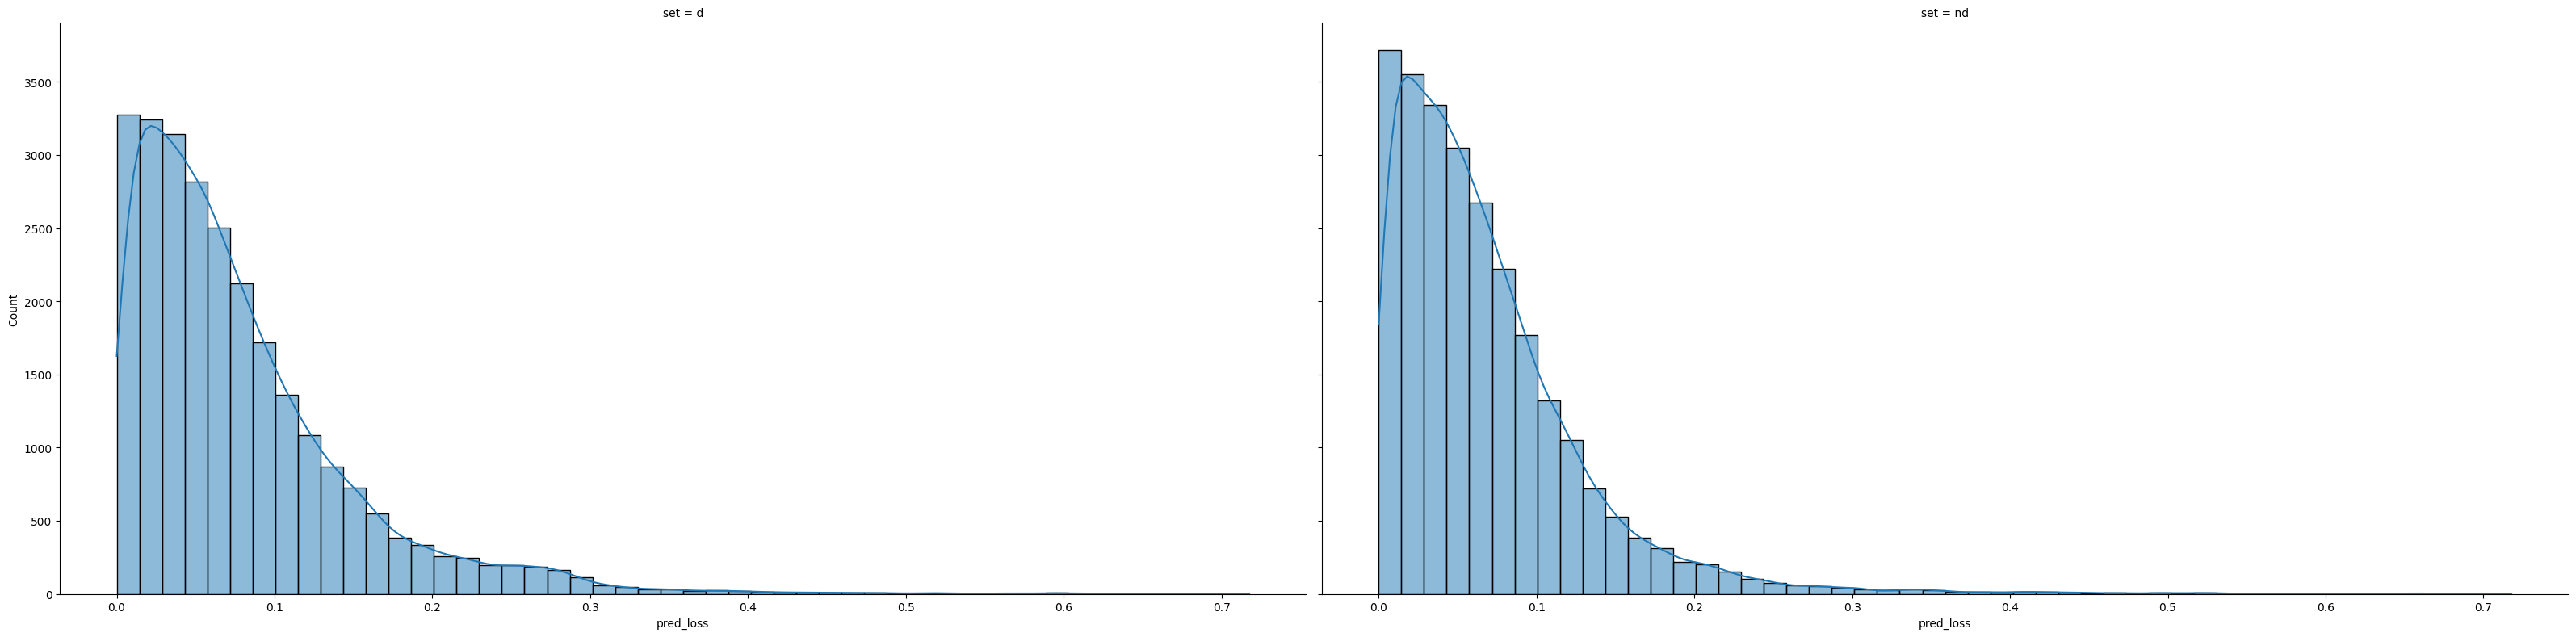

In [24]:
sns.displot(x = "pred_loss", data=preds, col = "set", bins = 50, kde = True, height = 8, aspect = 2);

## Sólo filtro de 2016

In [31]:
def metrics(results):
    tp = results.loc["d"]
    fp = results.loc["nd"]
    tn = 100-results.loc["nd"]
    fn = 100-results.loc["d"]
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp /( tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

In [32]:
results_m_3sd = preds.query(f"date >= '01-01-2016' and pred_loss >= {mu + 3*sd}").ts_id.drop_duplicates().str.split("_", expand=True)[1].value_counts()
metrics(results_m_3sd)

(0.81, 0.7767857142857143, 0.87, 0.820754716981132)

In [120]:
results_m_3sd

d     87
nd    25
Name: 1, dtype: int64

## Separación por clase

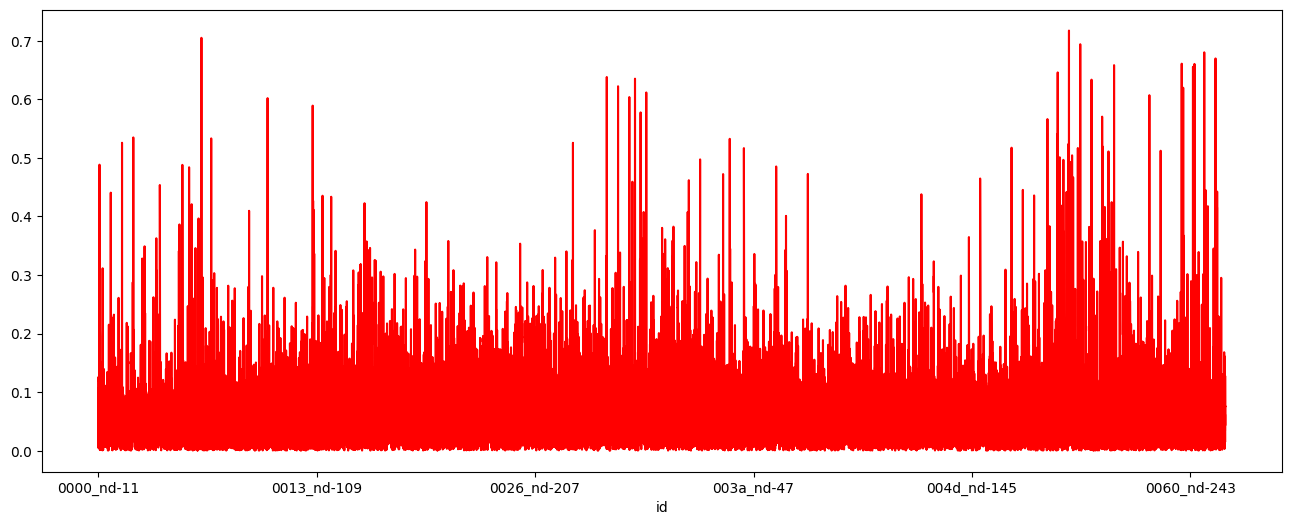

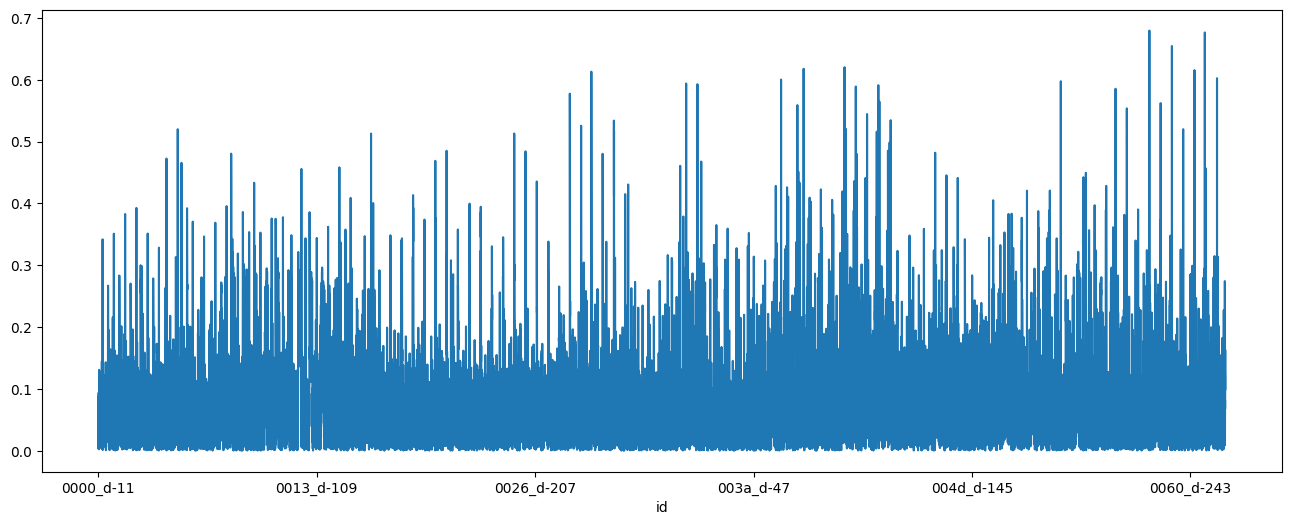

In [64]:
nd = preds.query('set == "nd"')
d = preds.query('set == "d"')

nd.set_index("id")["pred_loss"].plot(figsize=(16,6), color = "r")
plt.show()
d.set_index("id")["pred_loss"].plot(figsize=(16,6));



In [70]:
WINDOW = 10
preds["anomaly"] = np.where(preds.pred_loss > mu + 3*sd, 1, 0)
preds["cum_anomaly"] = preds.anomaly.rolling(WINDOW).sum().shift(-WINDOW)
preds

id  pred_loss       date      ndvi    ts_id  ndvi_null set  \
0        0000_d-11   0.085215 2000-11-30  0.462208   0000_d      False   d   
1        0000_d-12   0.060724 2000-12-31  0.462337   0000_d      False   d   
2        0000_d-13   0.054204 2001-01-31  0.466720   0000_d      False   d   
3        0000_d-14   0.085742 2001-02-28  0.461520   0000_d      False   d   
4        0000_d-15   0.022278 2001-03-31  0.515035   0000_d      False   d   
...            ...        ...        ...       ...      ...        ...  ..   
51595  0063_nd-264   0.049220 2021-12-31  0.610939  0063_nd      False  nd   
51596  0063_nd-265   0.075291 2022-01-31  0.566278  0063_nd      False  nd   
51597  0063_nd-266   0.074875 2022-02-28  0.563392  0063_nd      False  nd   
51598  0063_nd-267   0.076240 2022-03-31  0.547669  0063_nd      False  nd   
51599  0063_nd-268   0.044462 2022-04-30  0.591261  0063_nd      False  nd   

       anomaly  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
51595        0  
51596        0  
51597        0  
51598        0  
51599        0  

[51600 rows x 8 columns]

In [132]:
preds.query("anomaly == 1 and ndvi_null == True and date > '01-01-2016'")

id  pred_loss       date      ndvi   ts_id  ndvi_null set  \
3061  000b_d-234   0.325299 2019-06-30  0.070106  000b_d       True   d   
3063  000b_d-236   0.320962 2019-08-31  0.075515  000b_d       True   d   

      anomaly  cum_anomaly  
3061        1         10.0  
3063        1         10.0

In [128]:
def plot_anomalies(ide):
    preds.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
    ides = preds.query(f"date >= '01-01-2016' and ts_id == '{ide}' and anomaly == 1").id.tolist()
    dates = preds.query("date >= '01-01-2016' and id in @ides").date.tolist()
    plt.vlines(x = dates, ymin = 0, ymax = 1, color = "red", alpha = 0.3)
    plt.xticks(rotation=90)
    plt.title(f"{ide}")
    plt.show()


In [129]:
ANOMALY_THRESHOLD = 2
findings = preds.query(f"date >= '01-01-2016' and cum_anomaly > {ANOMALY_THRESHOLD}").drop_duplicates(subset = "ts_id")
metrics(findings.set.value_counts())


(0.79, 0.967741935483871, 0.6, 0.7407407407407407)

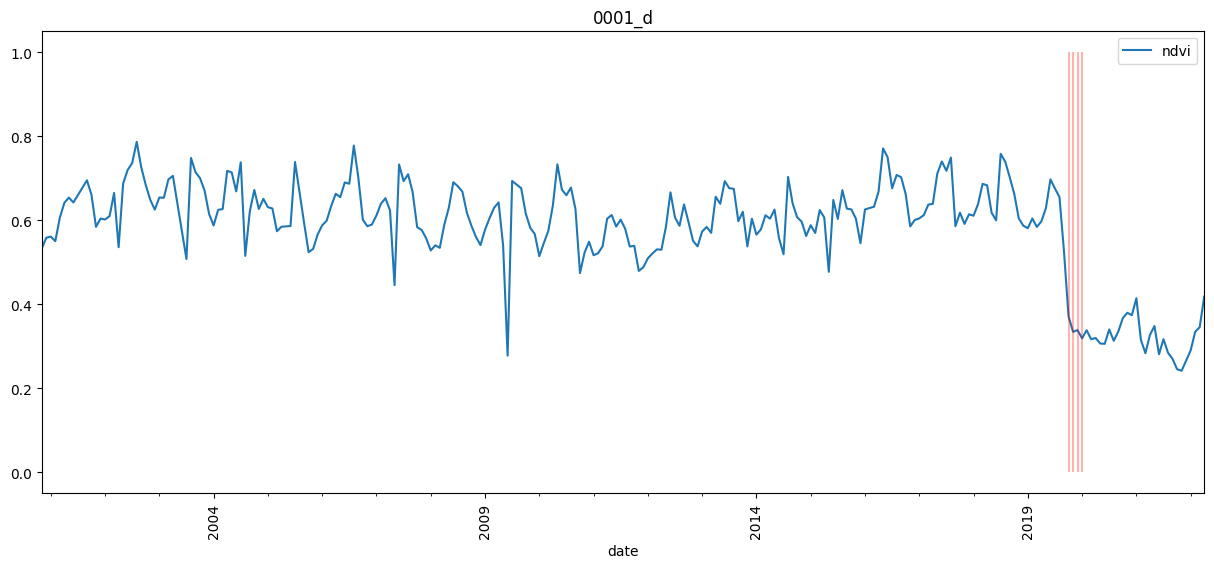

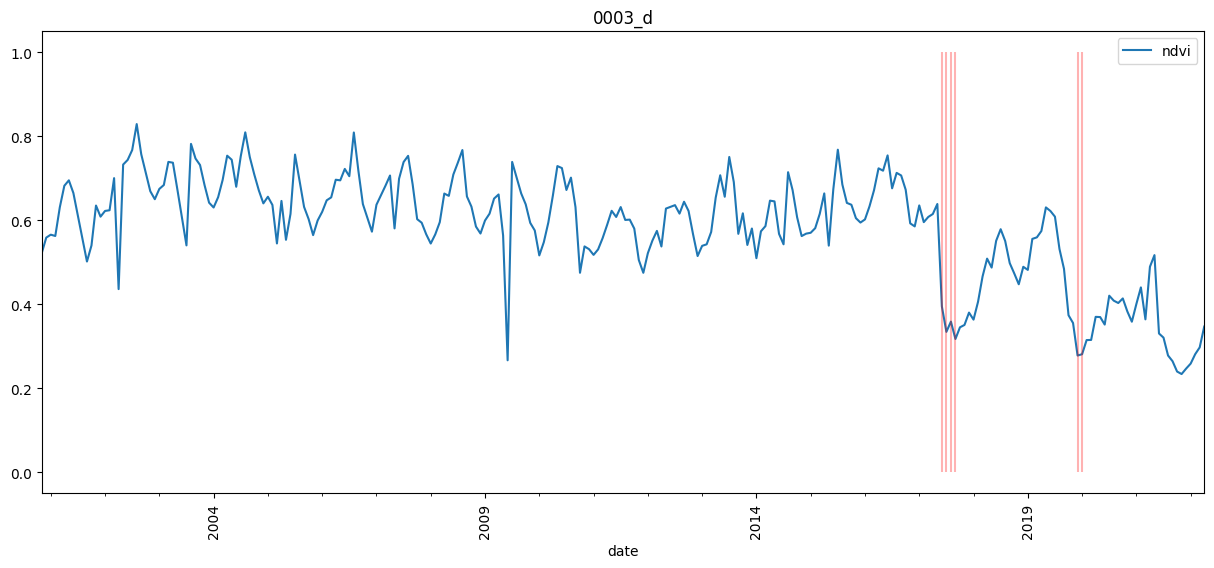

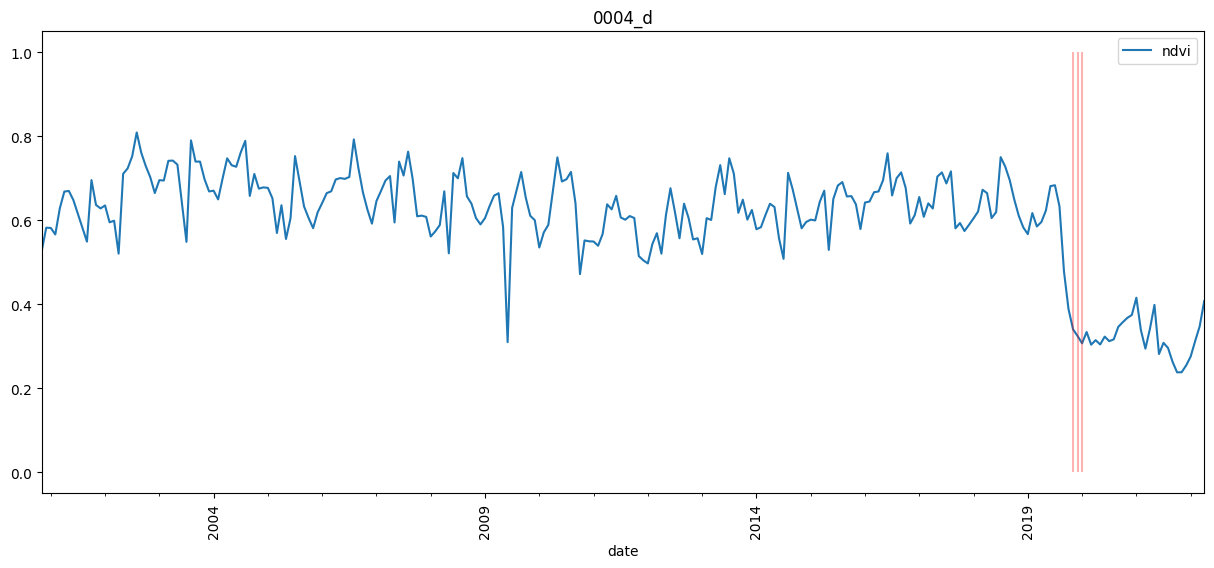

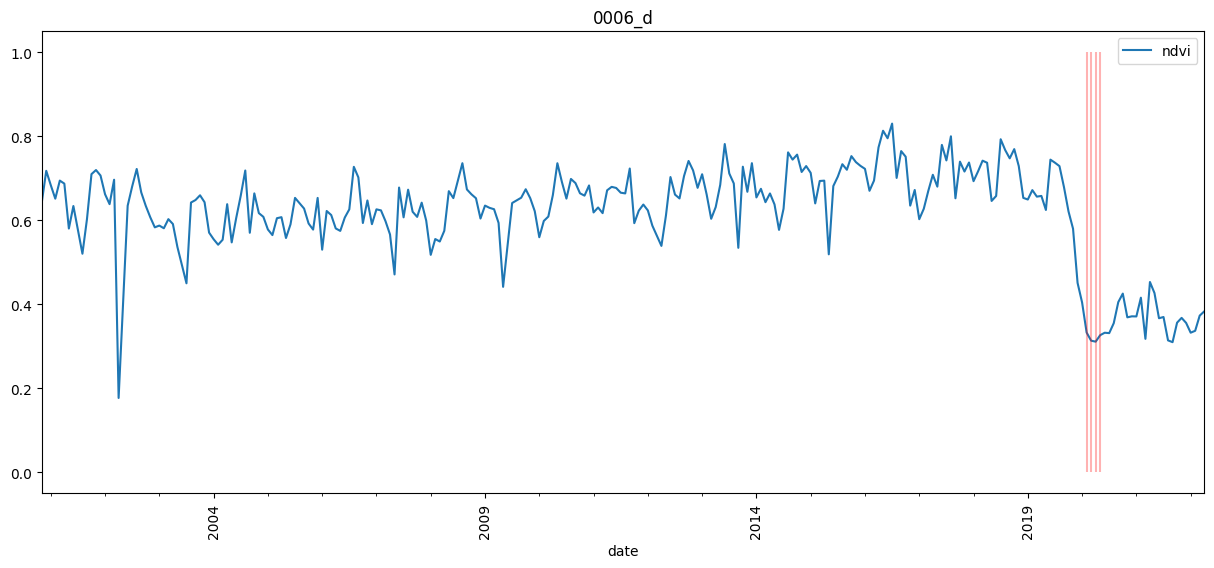

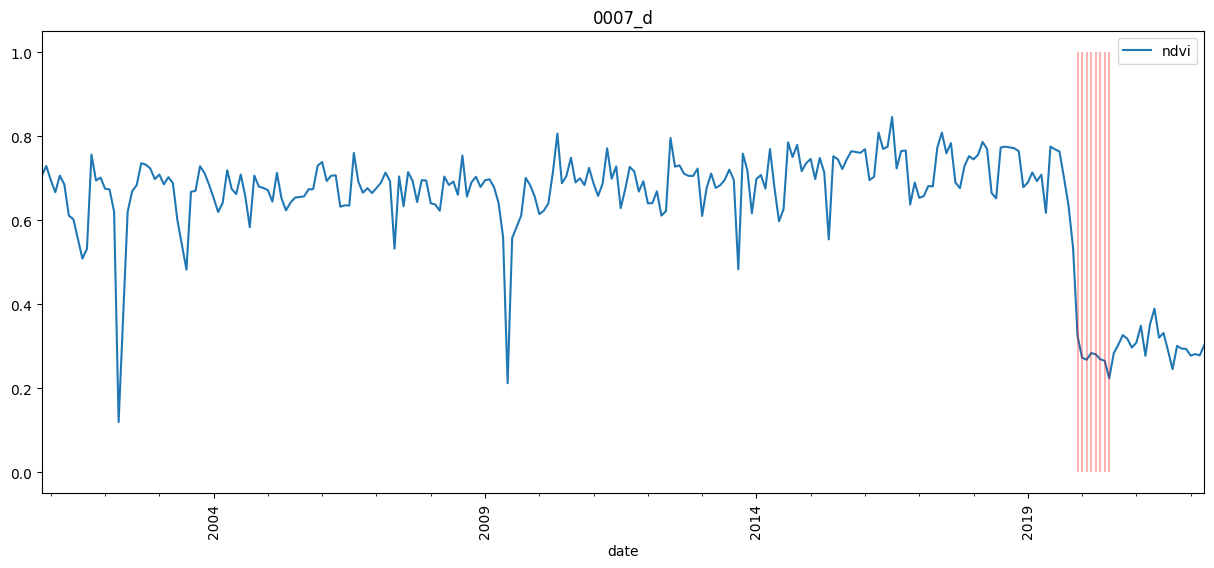

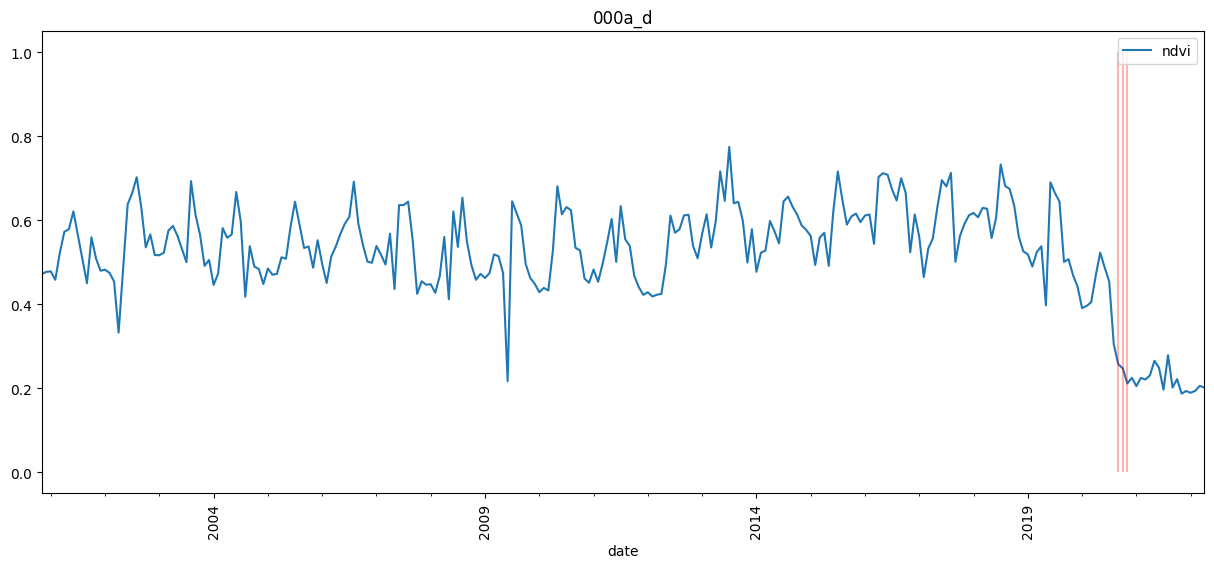

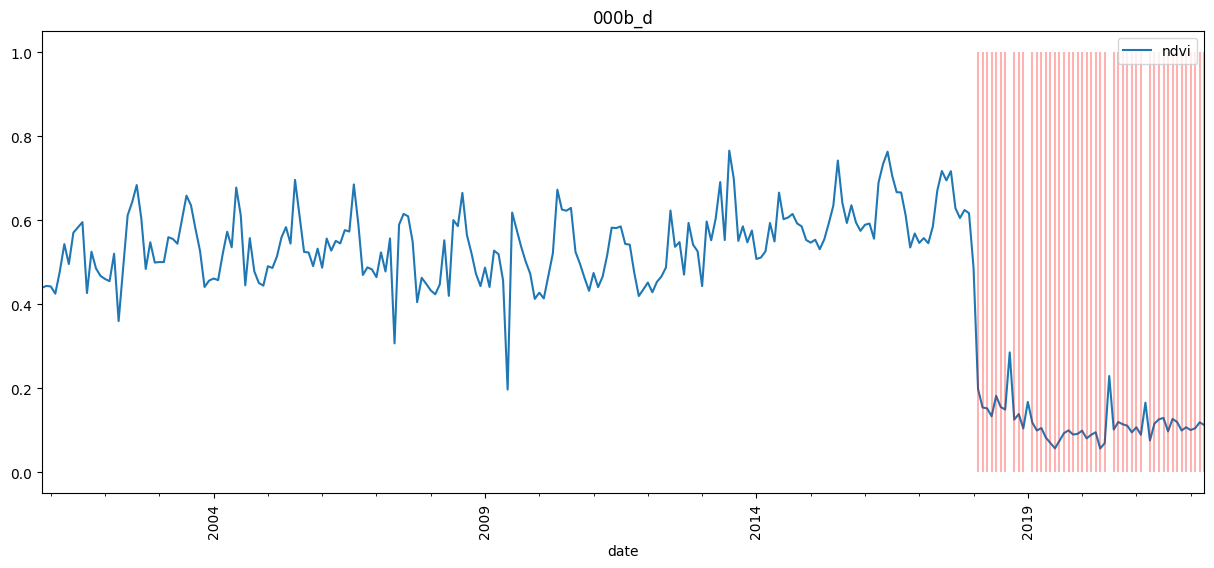

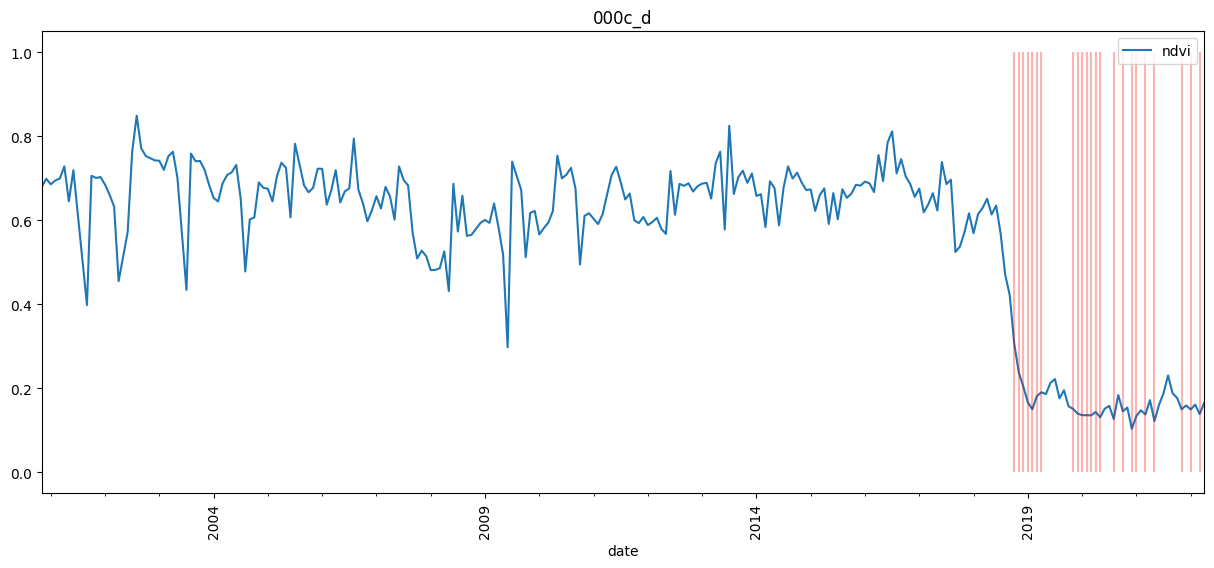

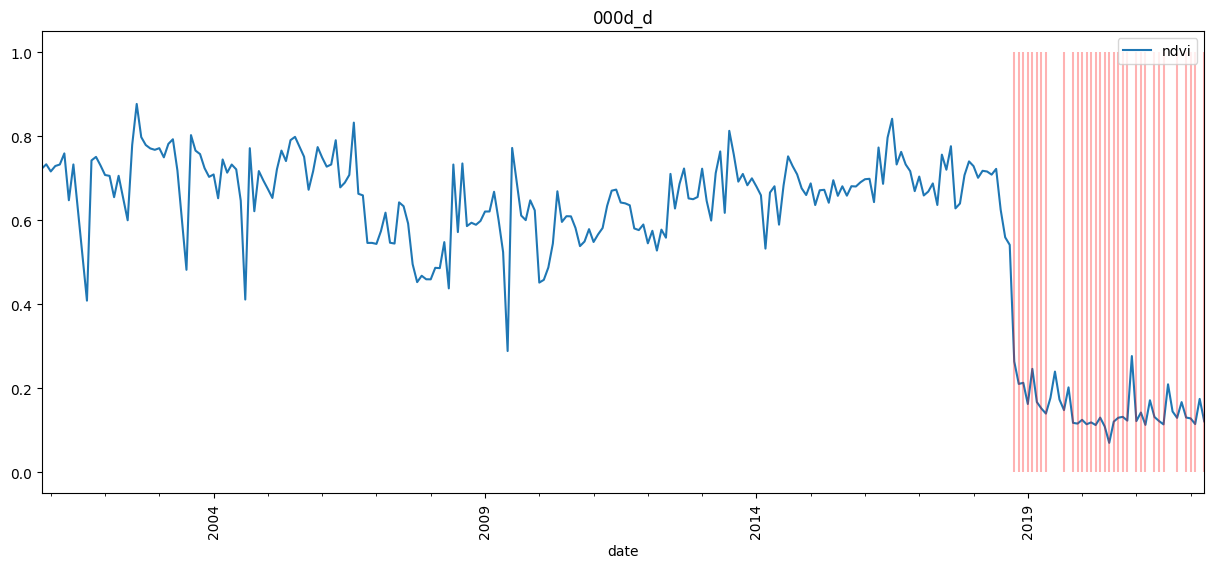

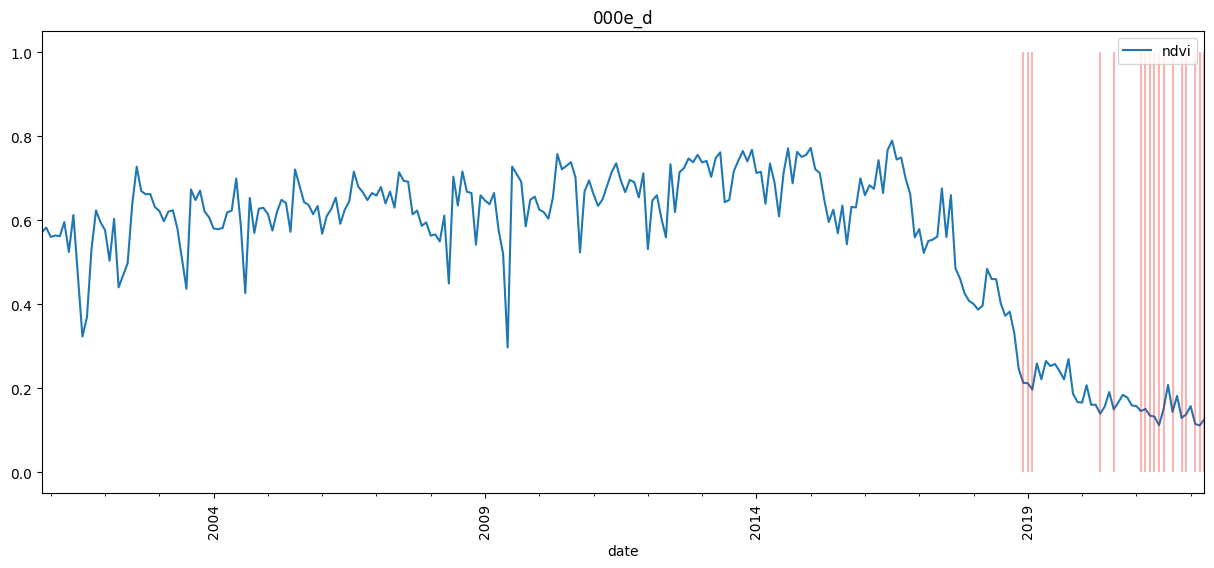

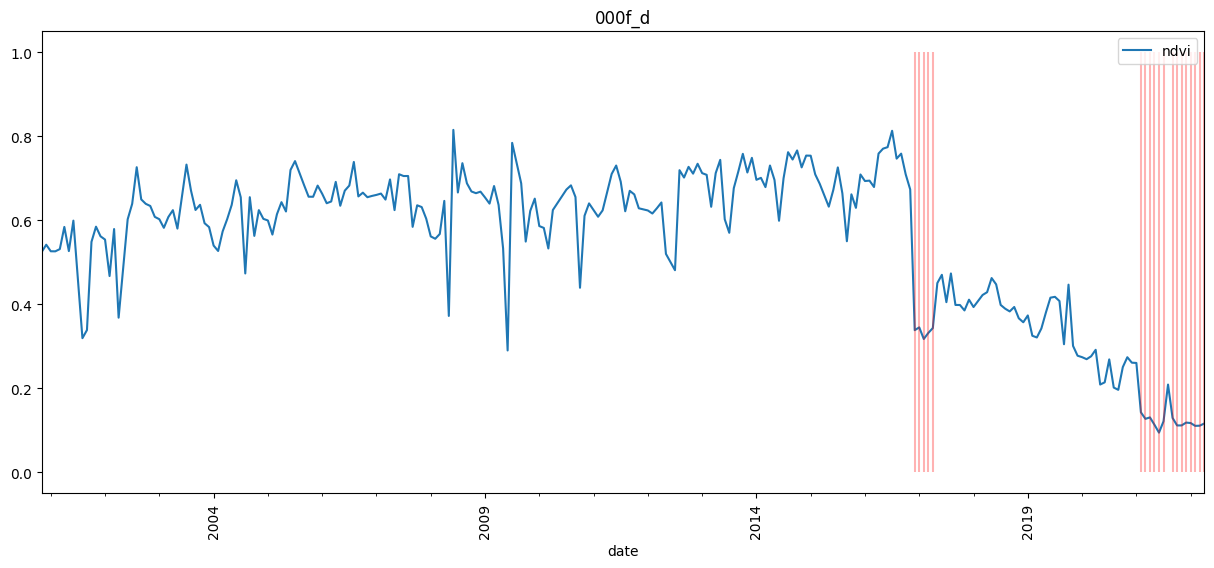

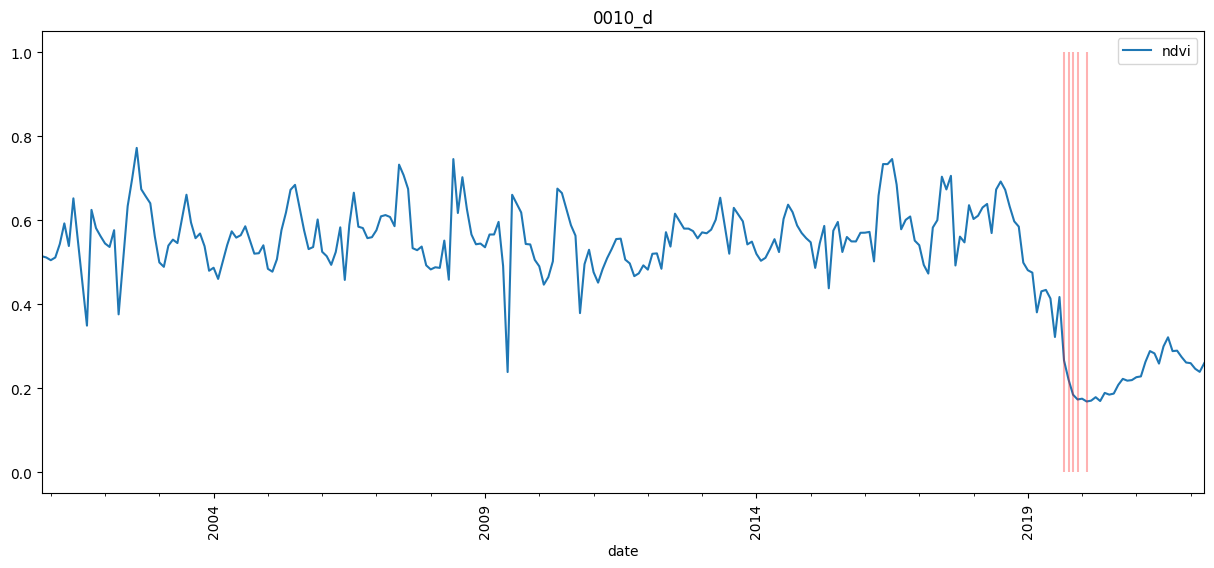

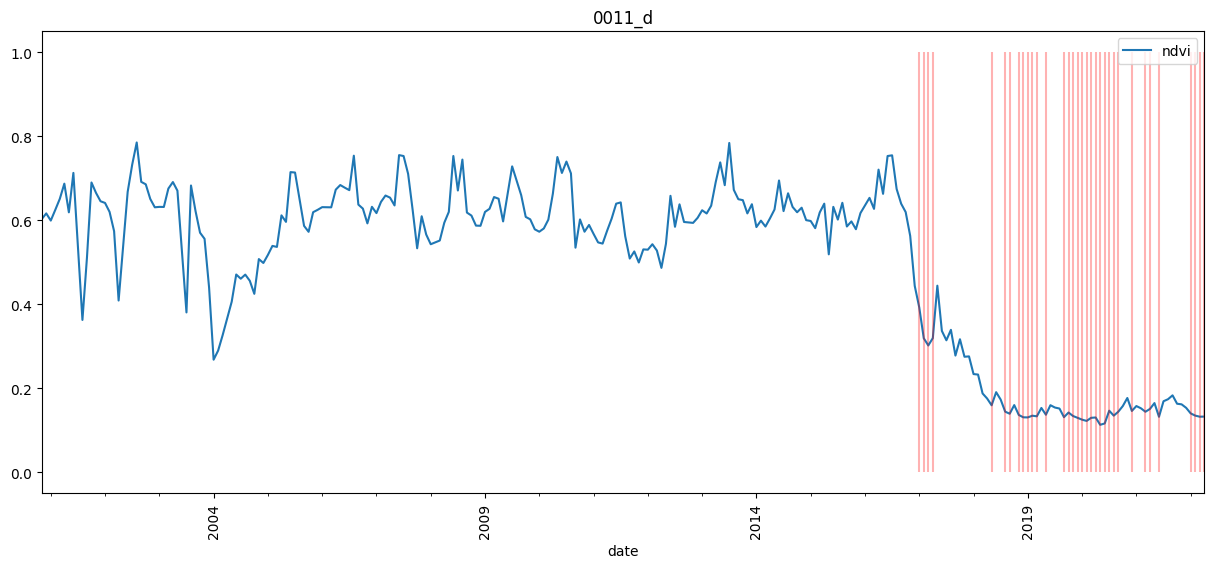

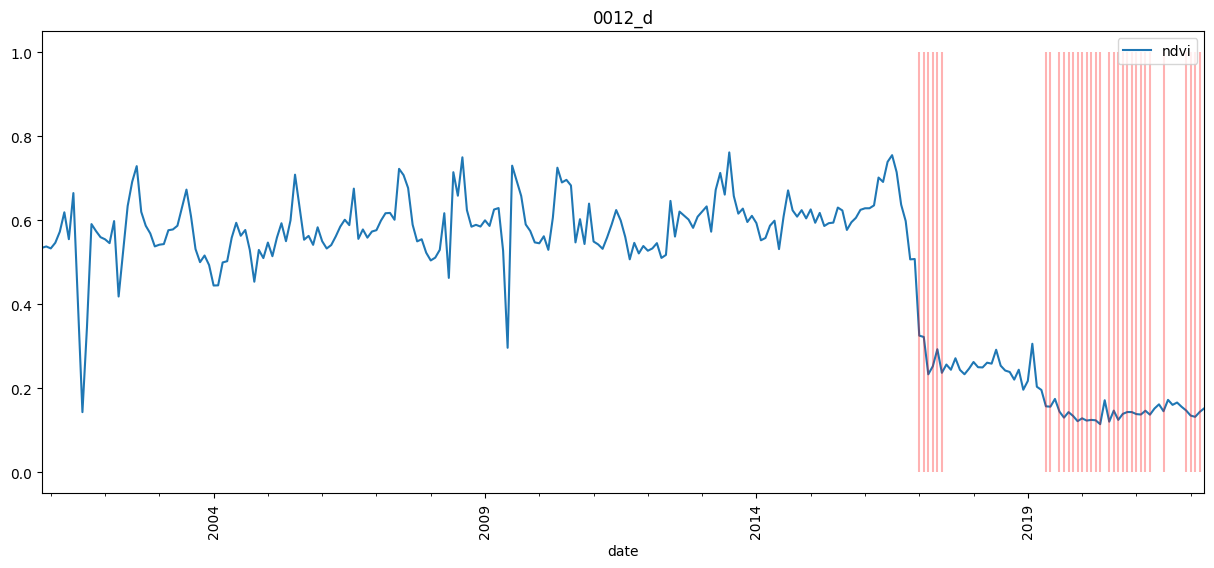

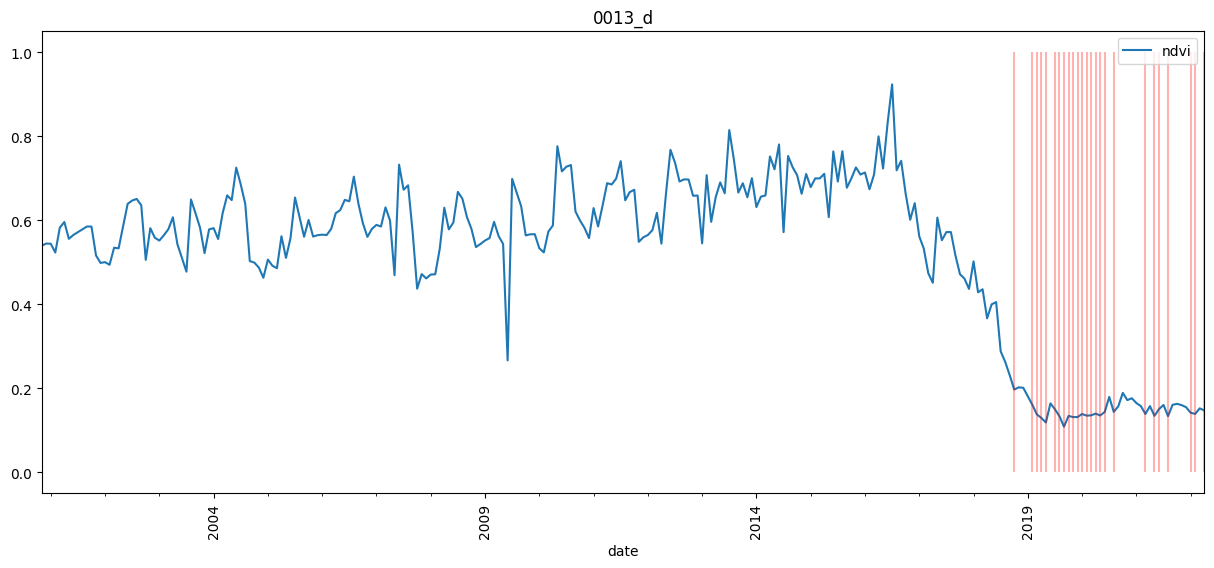

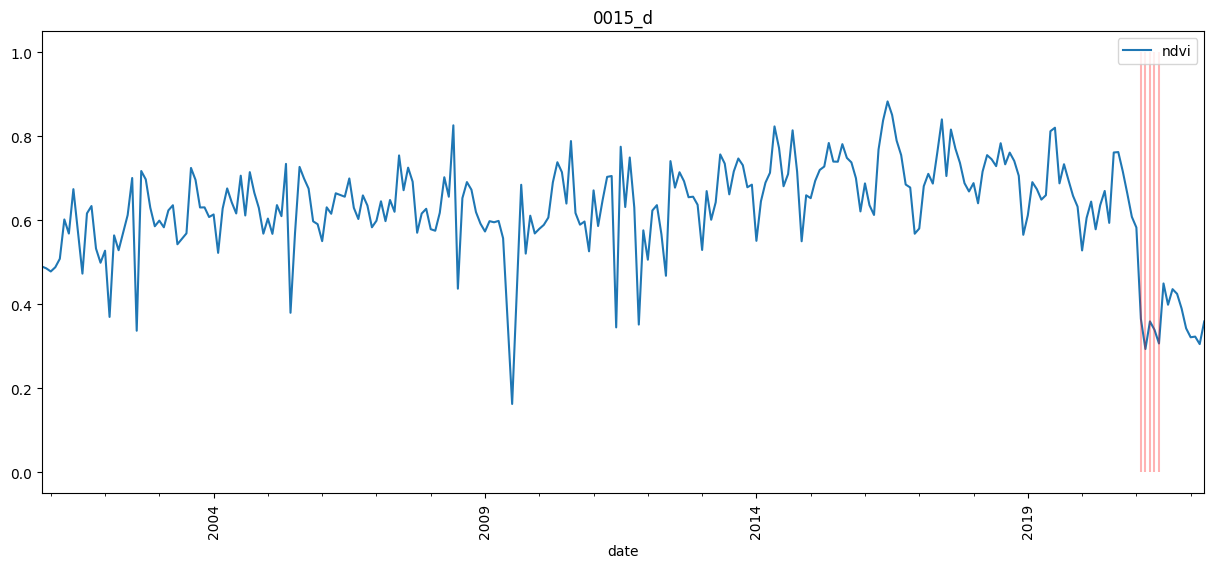

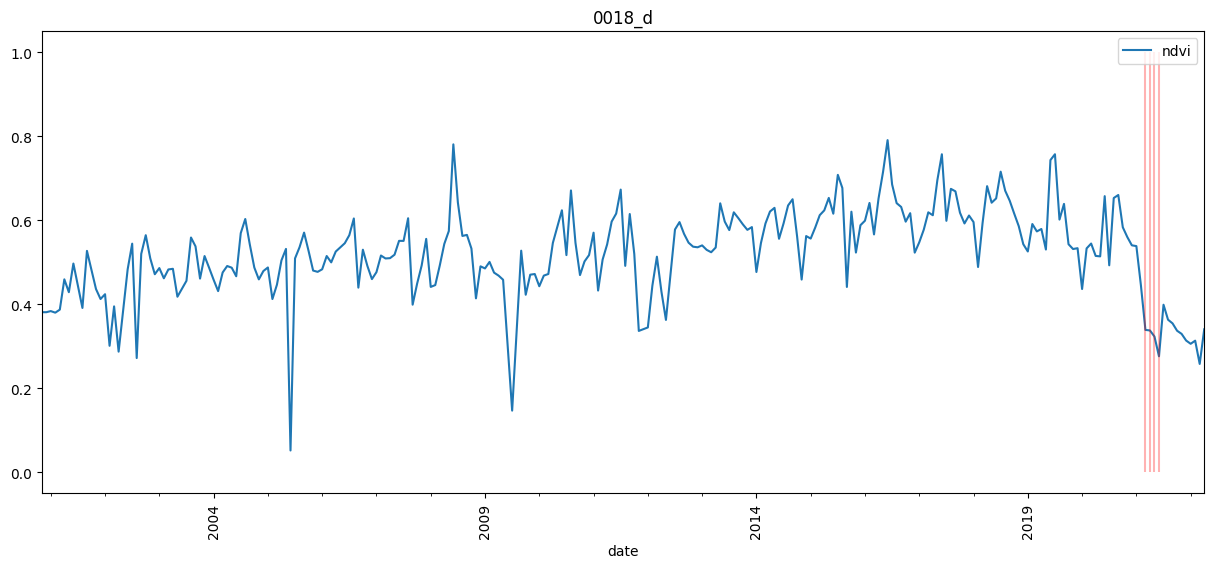

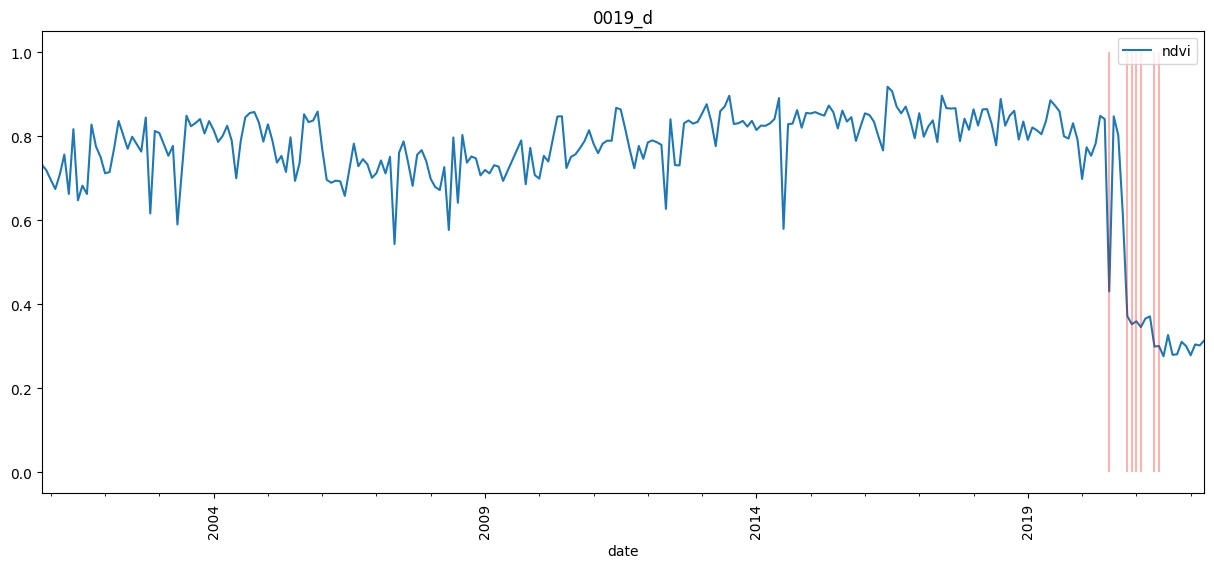

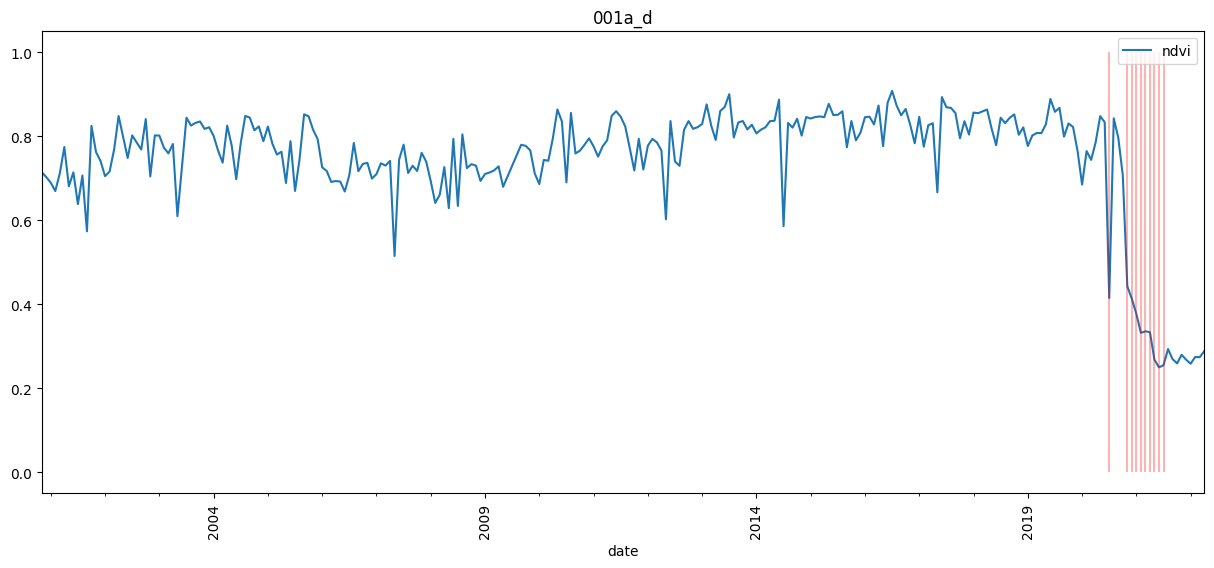

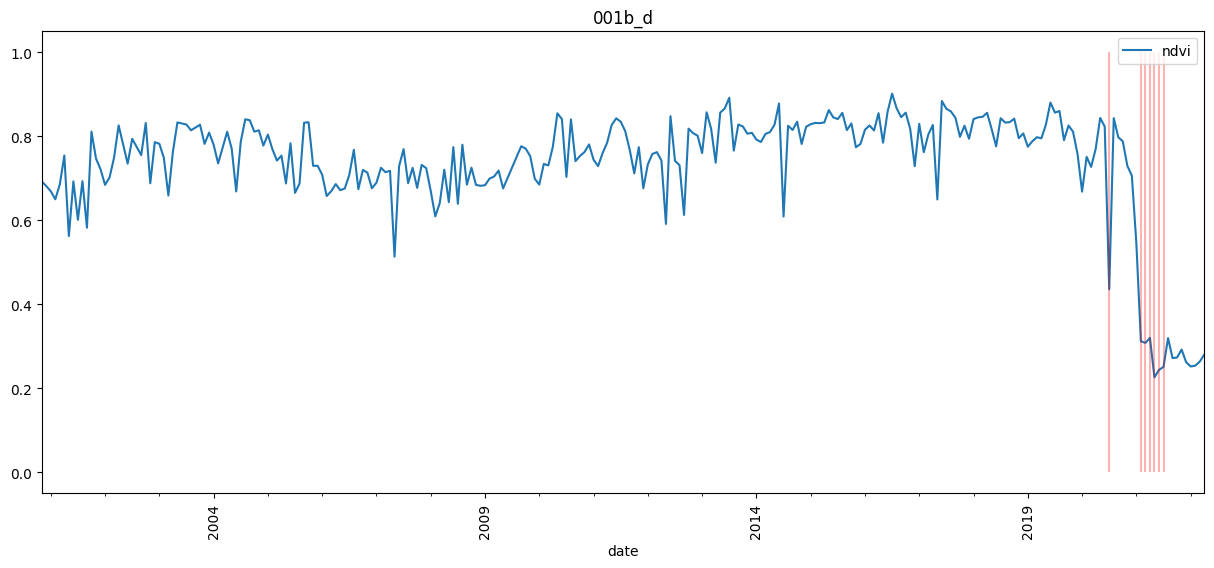

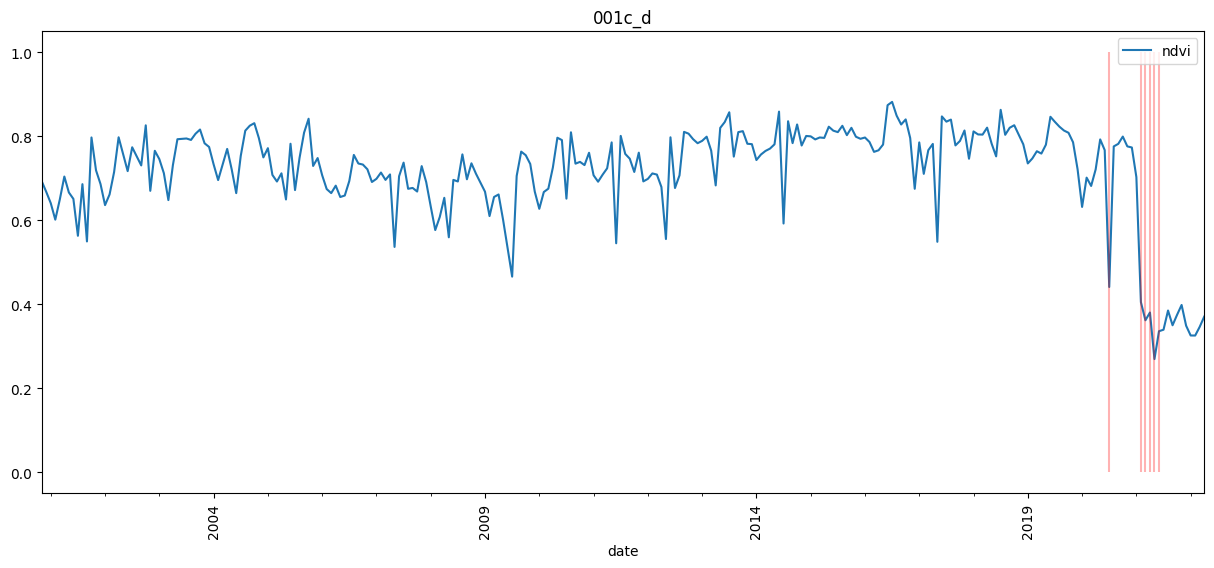

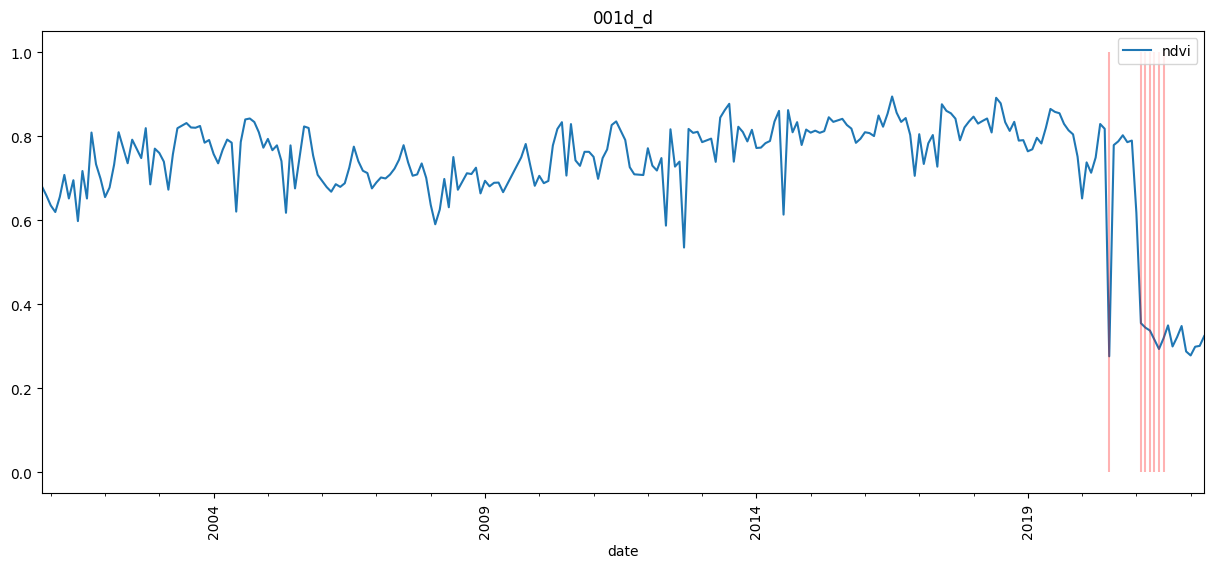

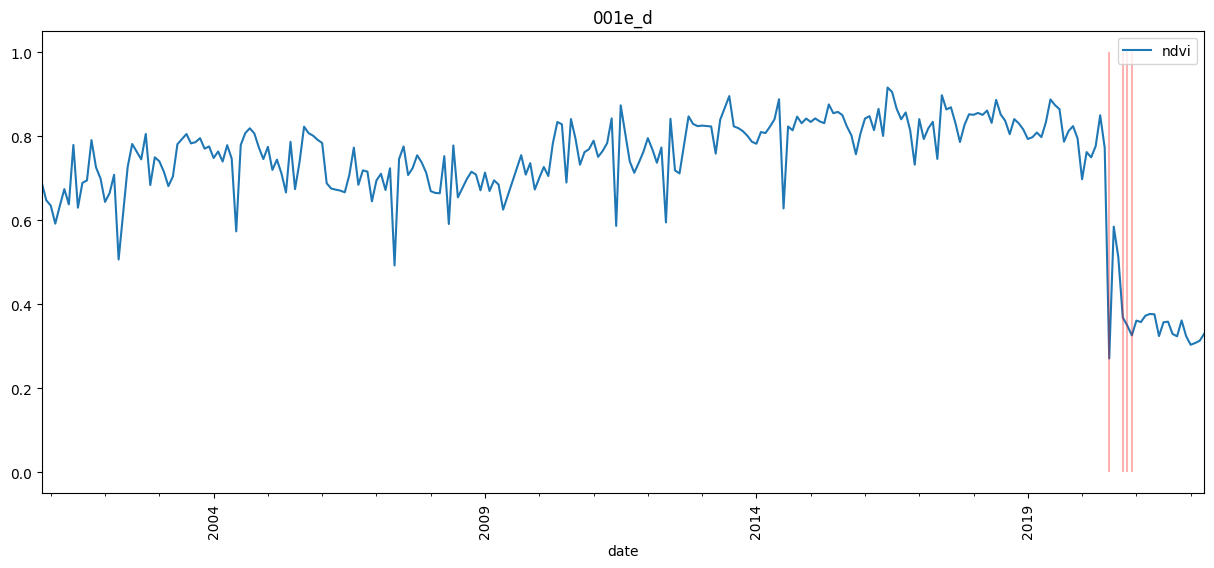

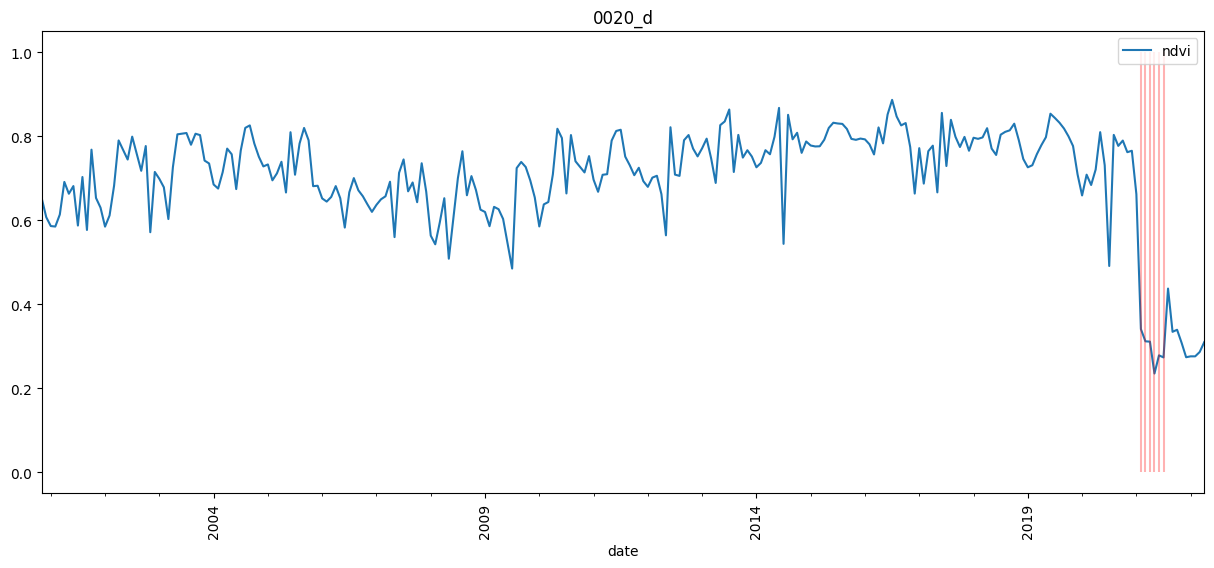

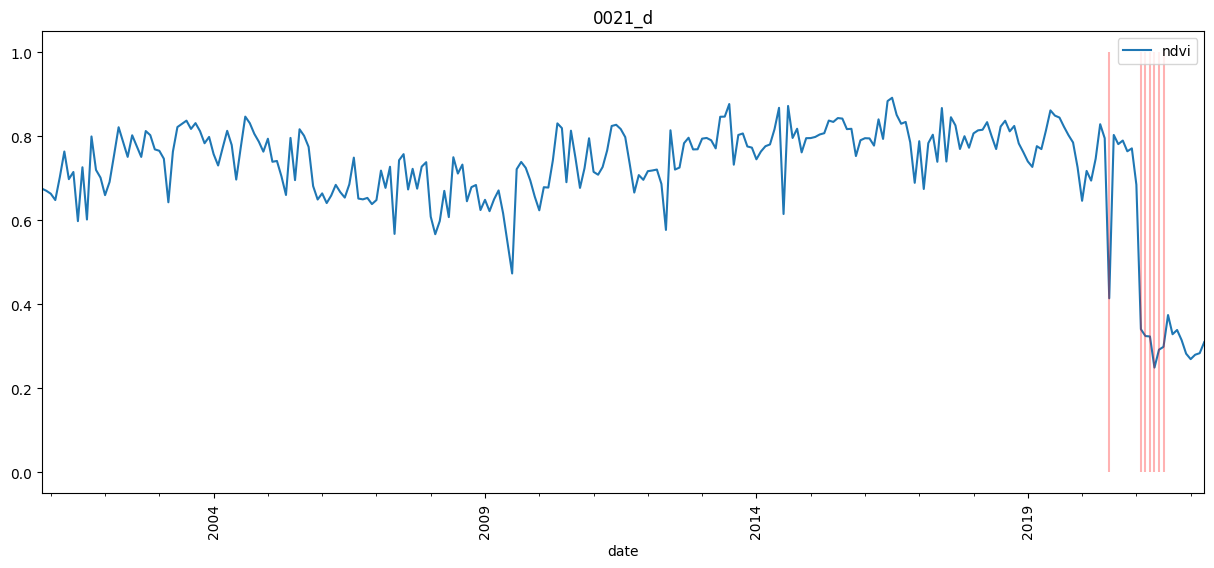

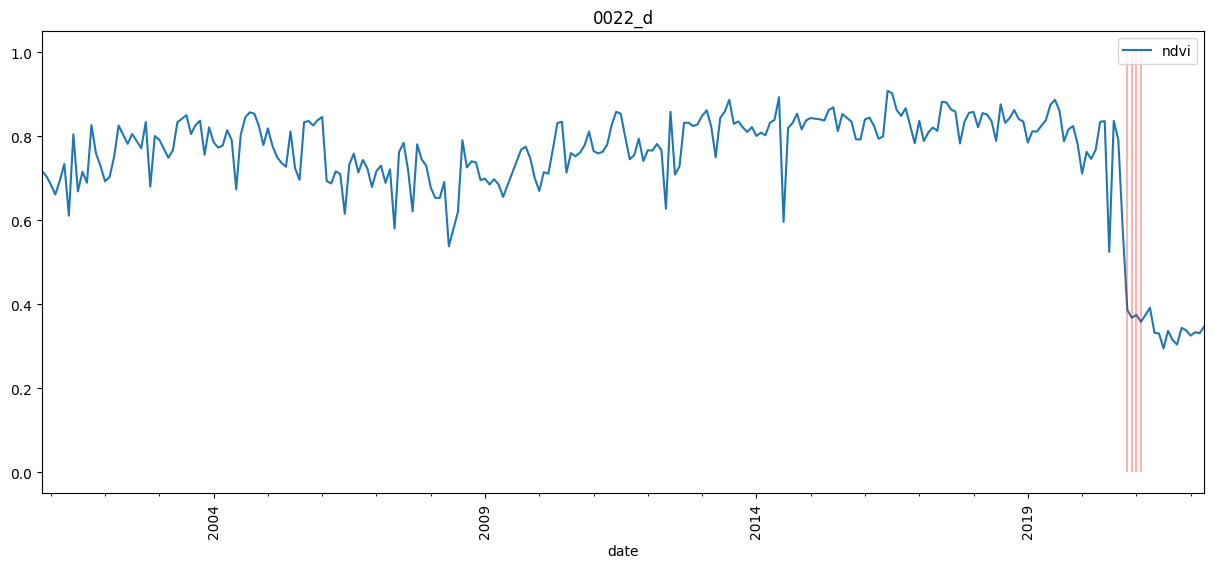

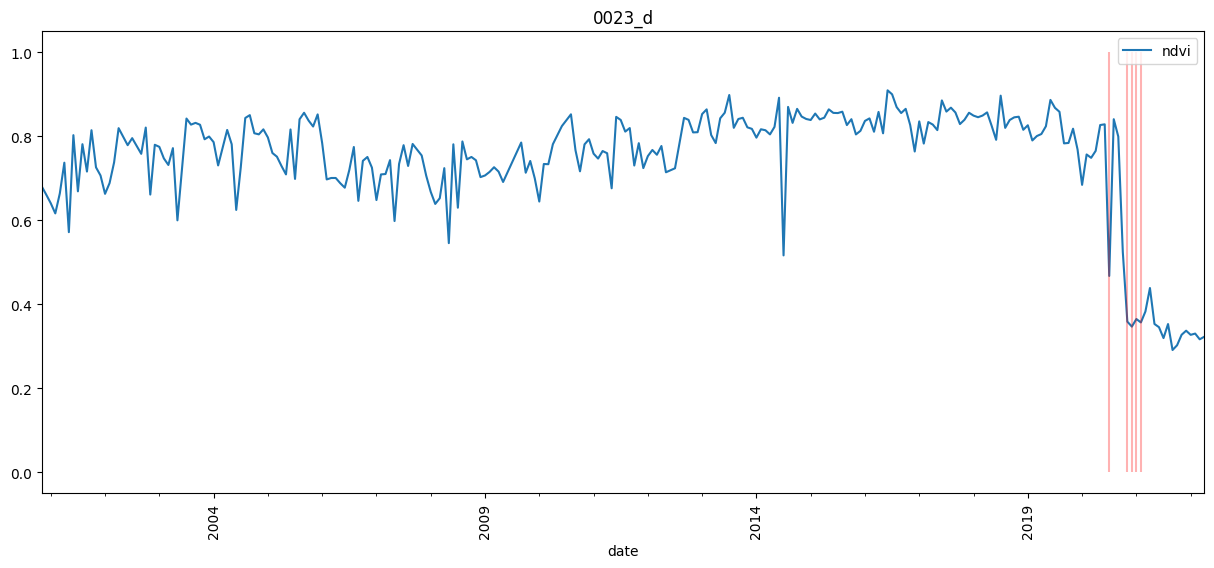

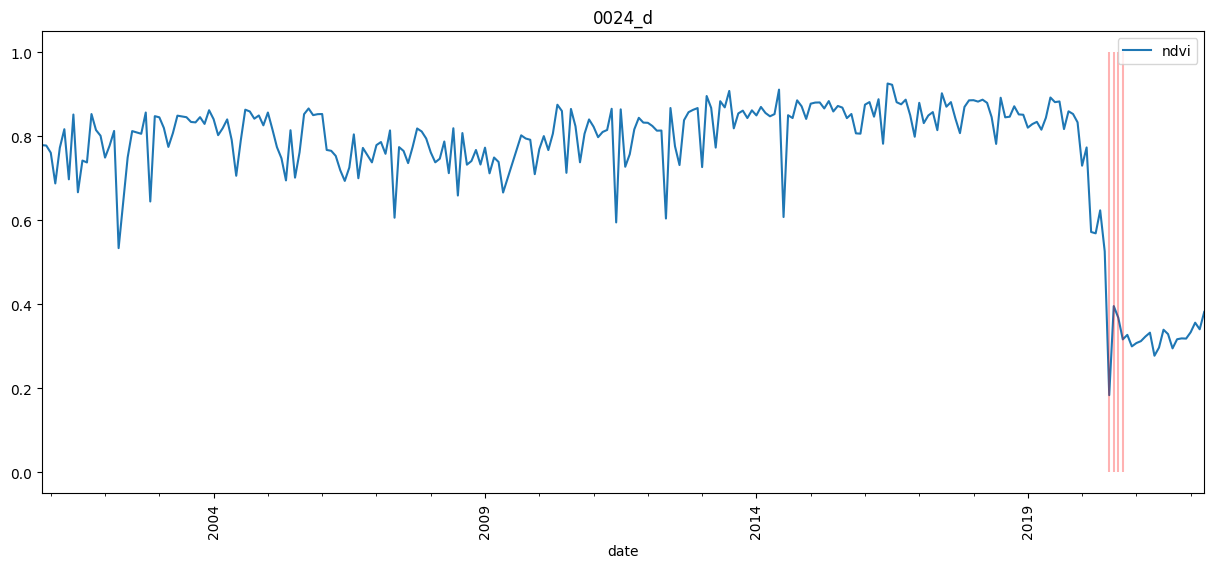

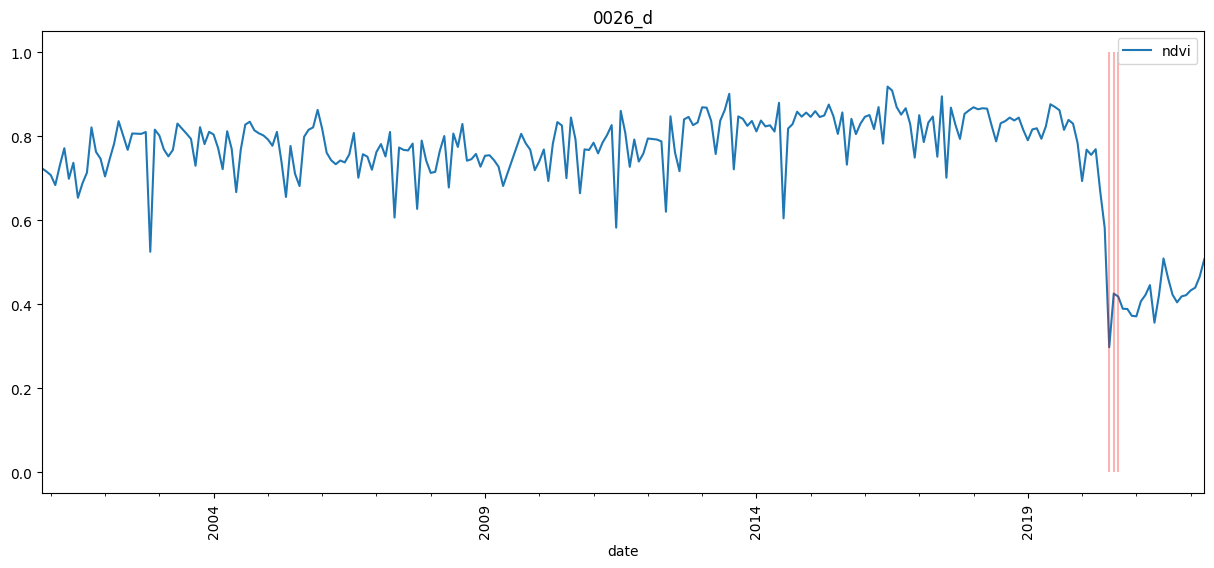

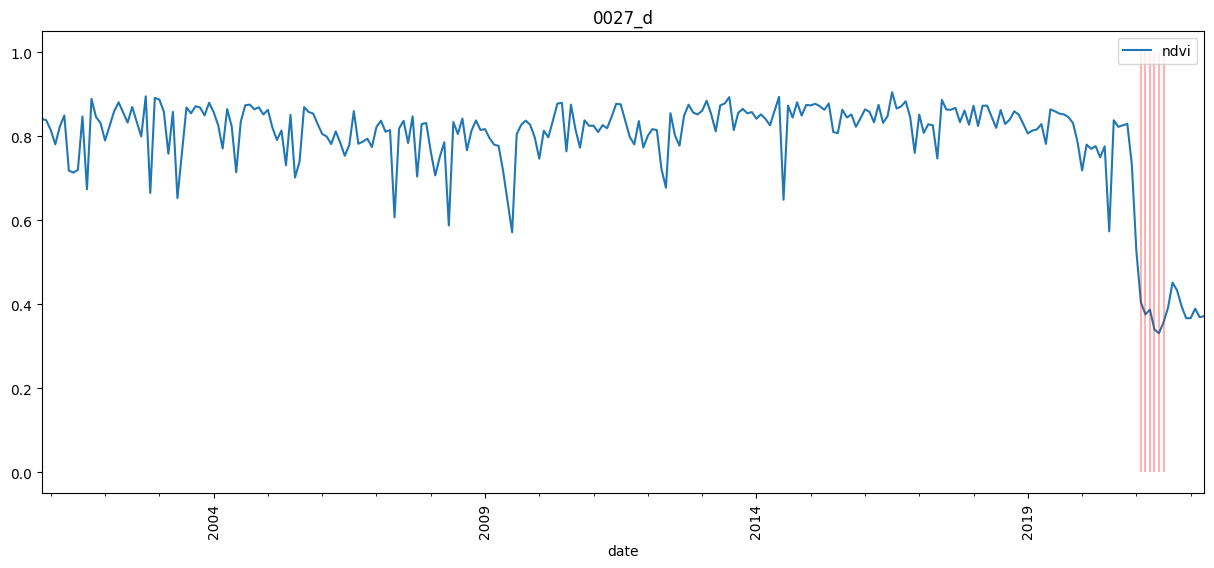

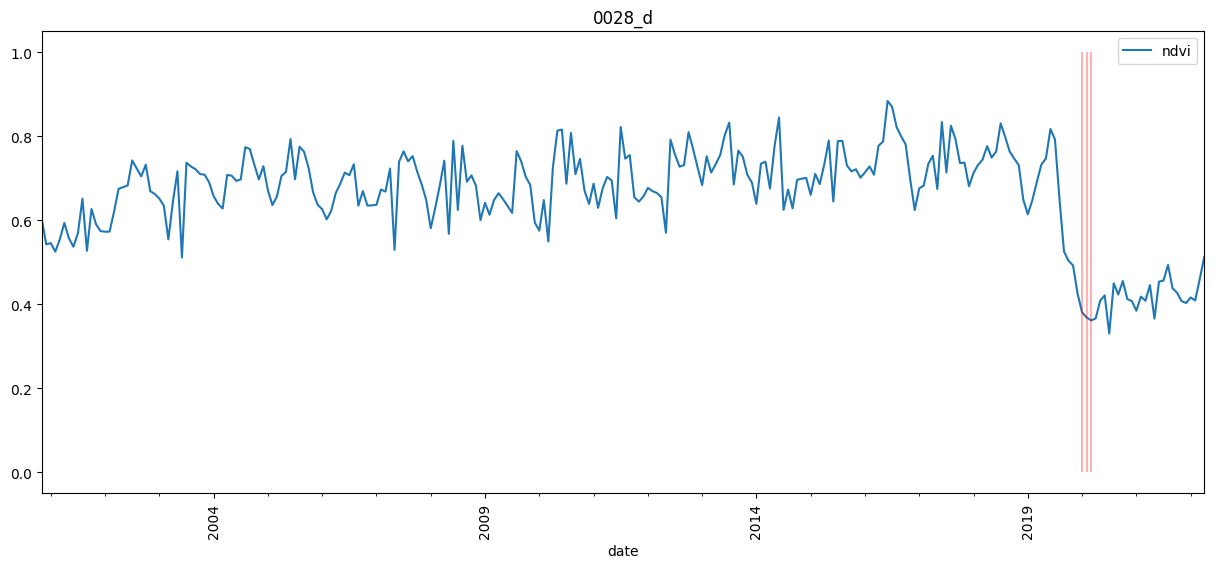

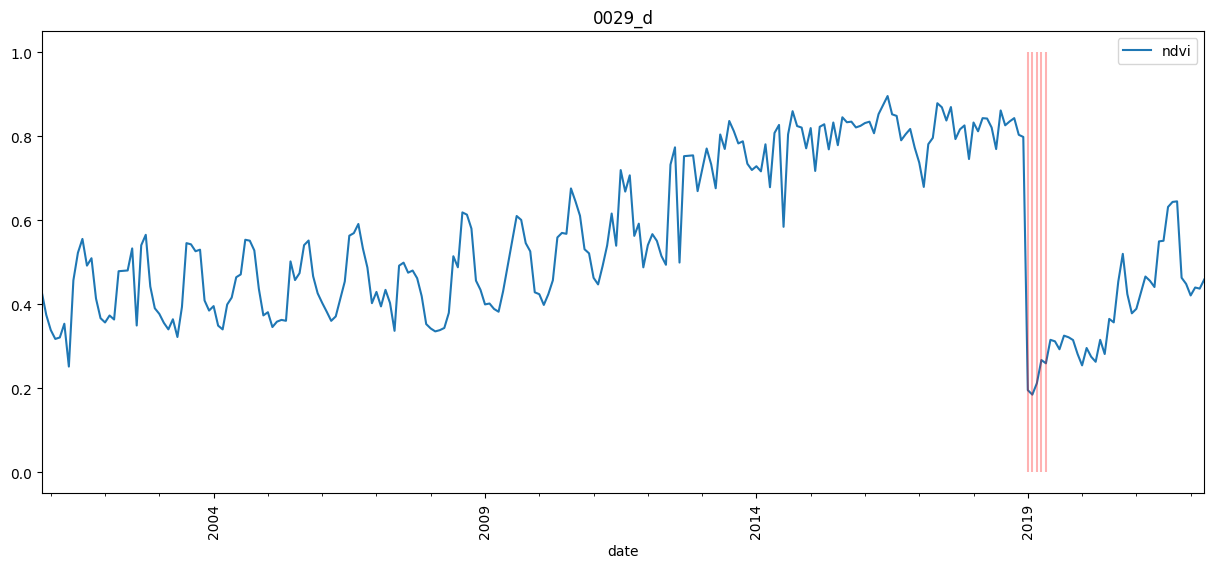

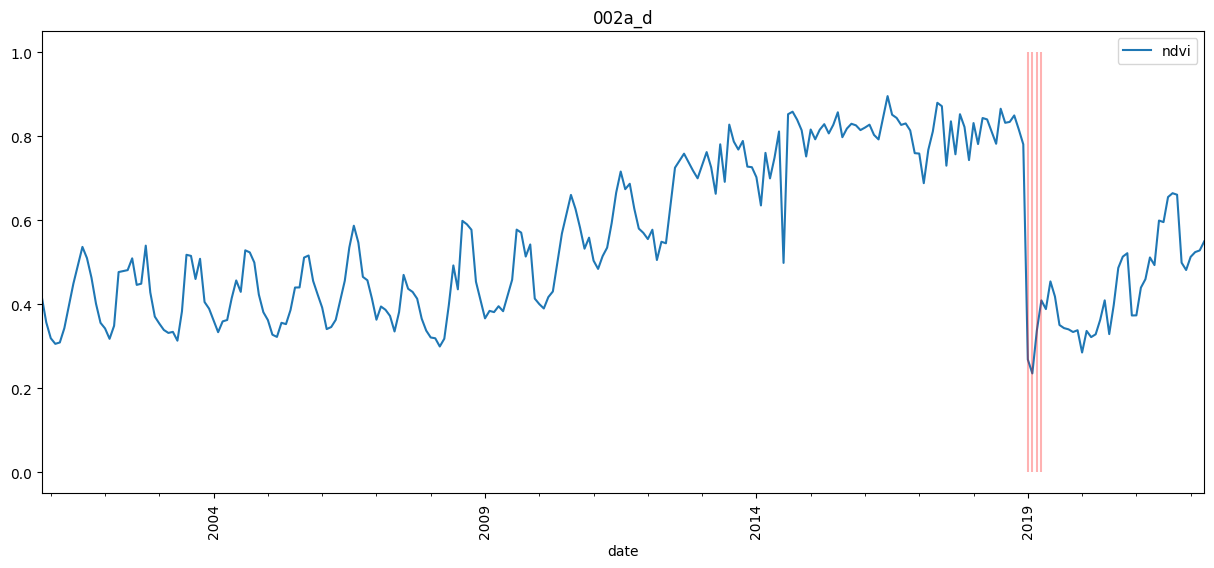

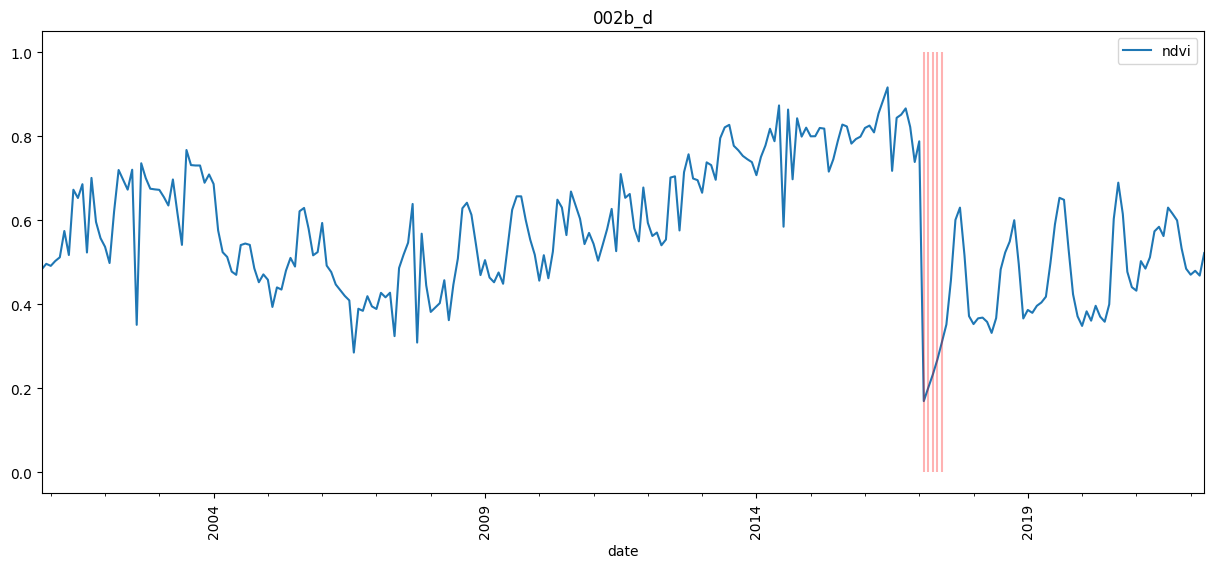

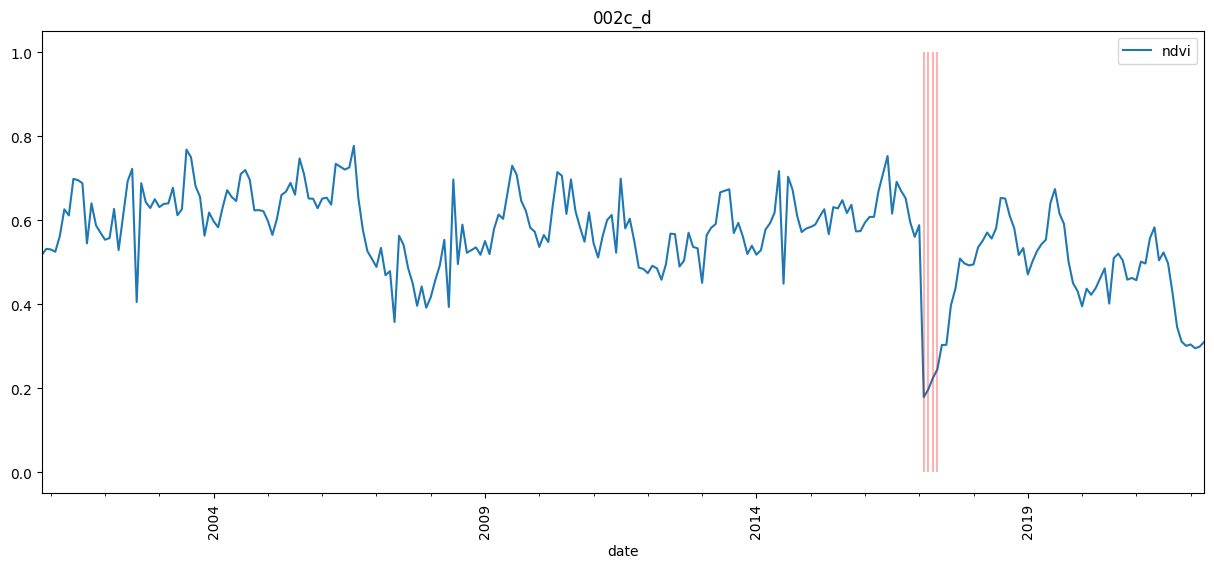

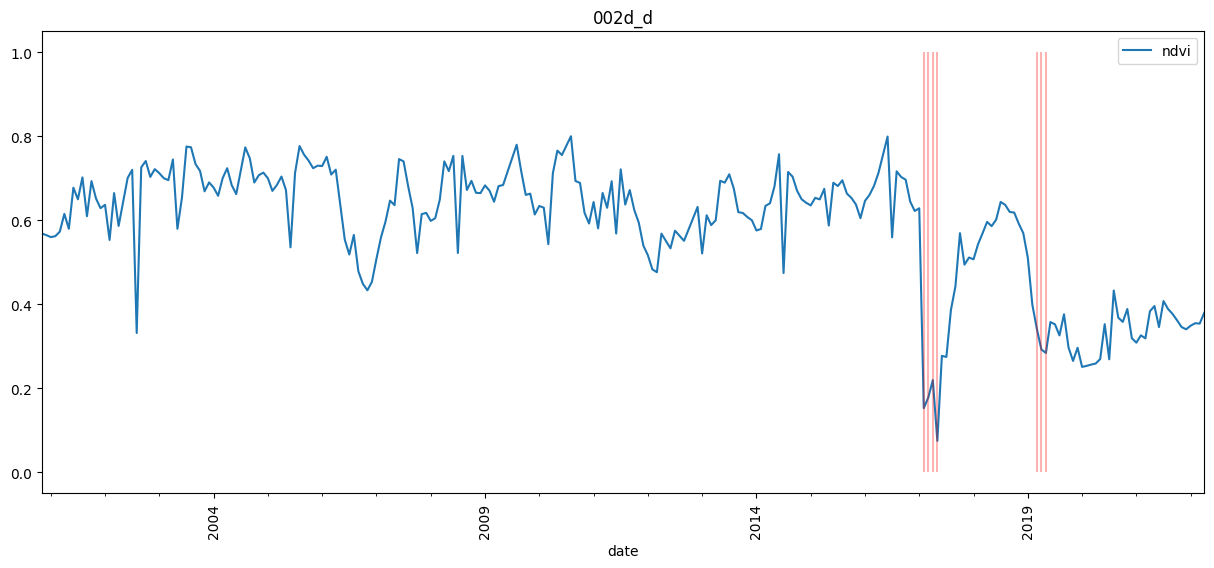

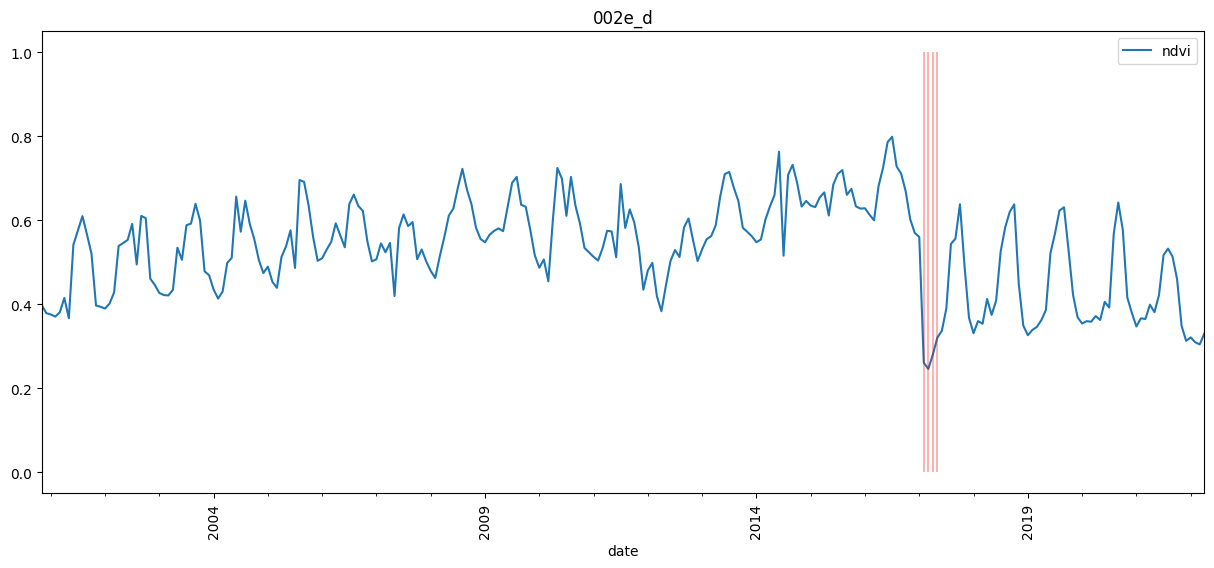

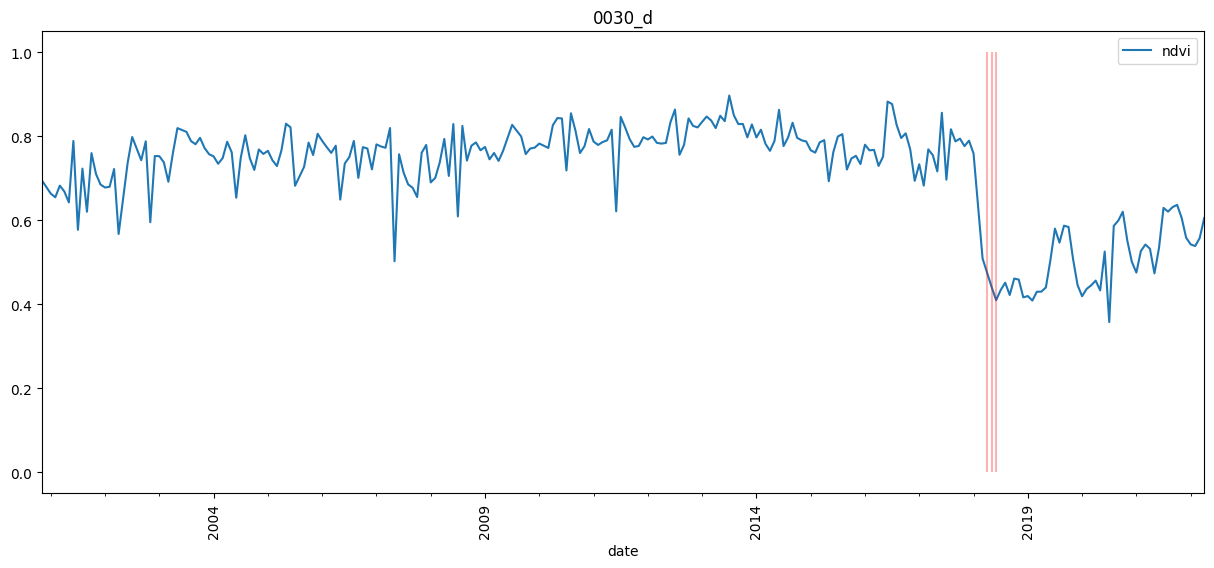

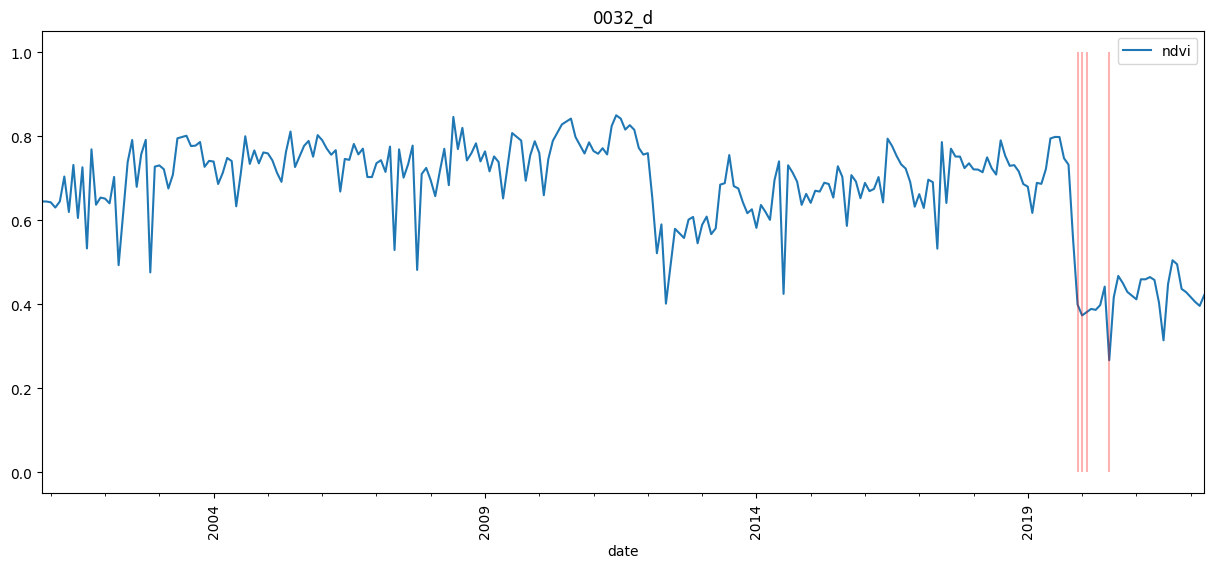

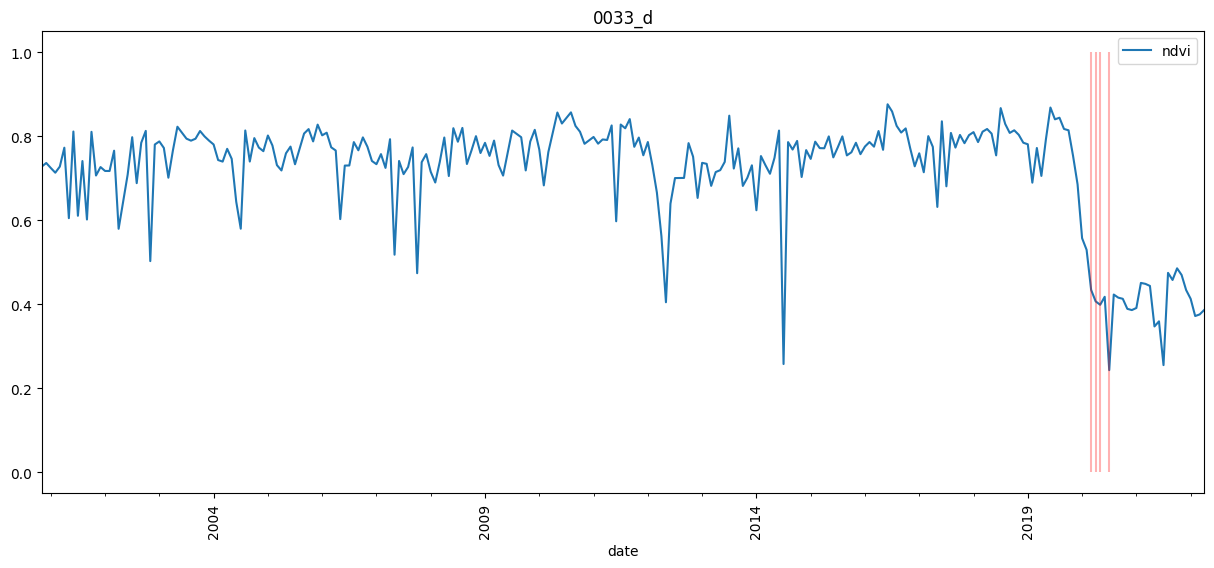

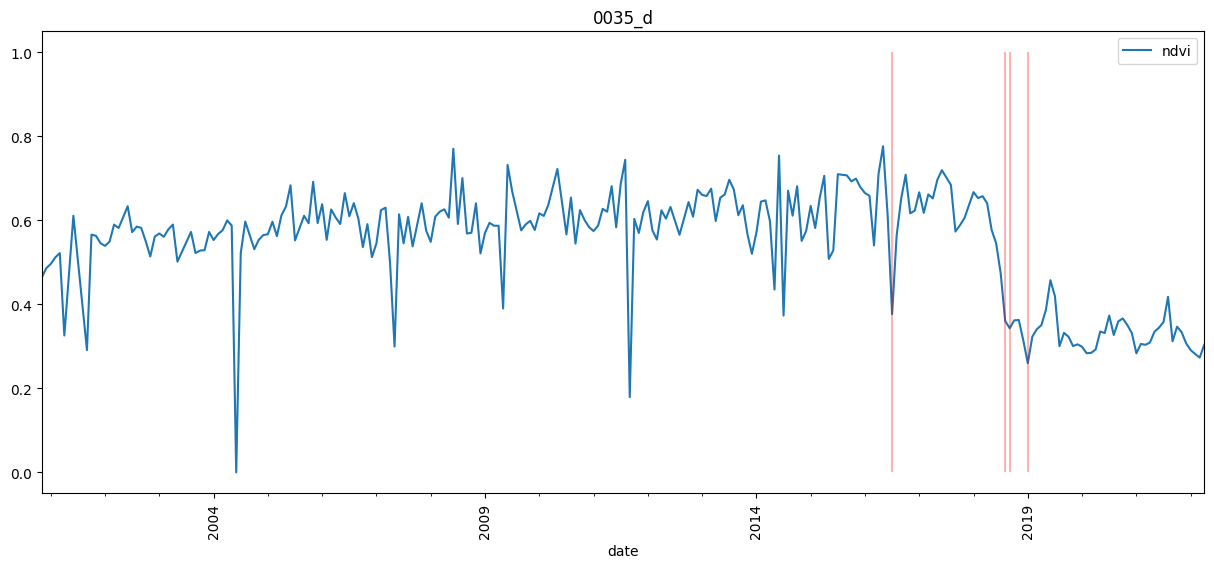

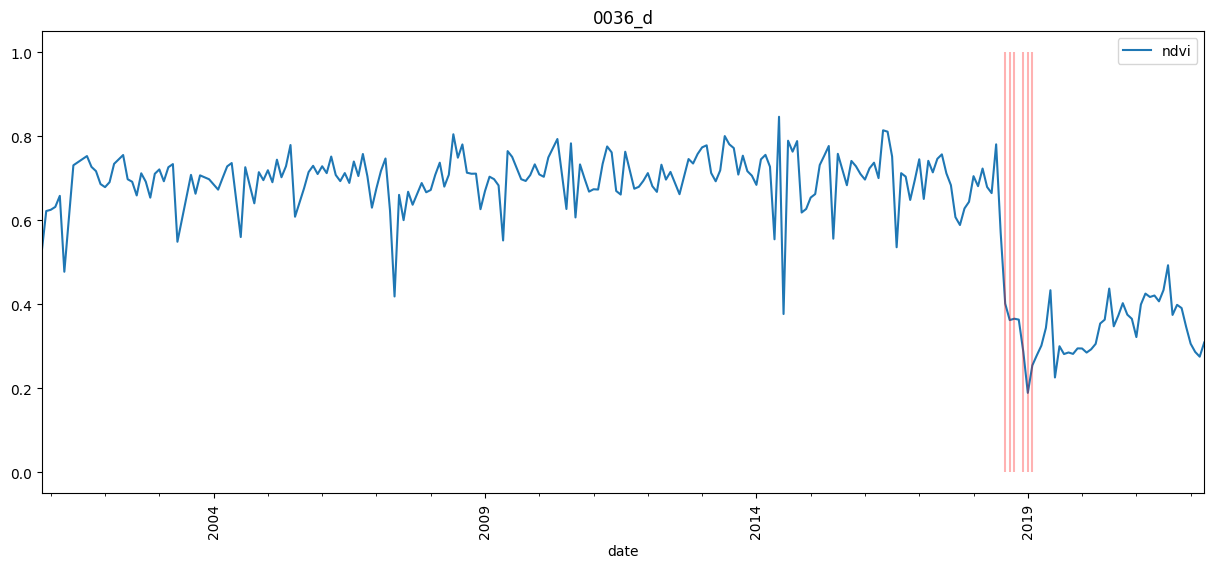

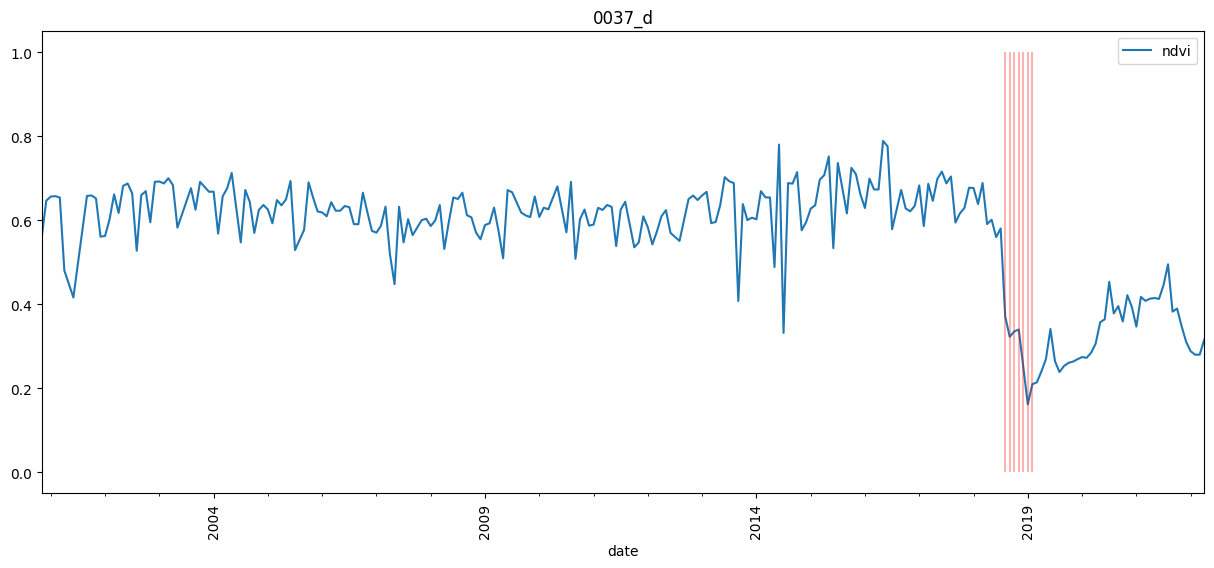

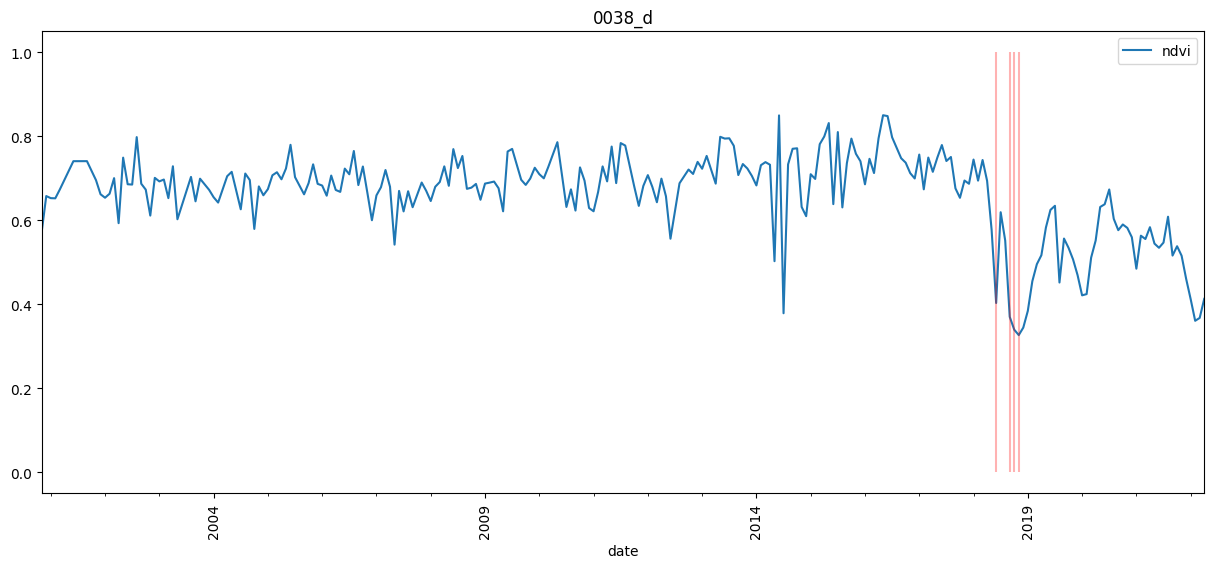

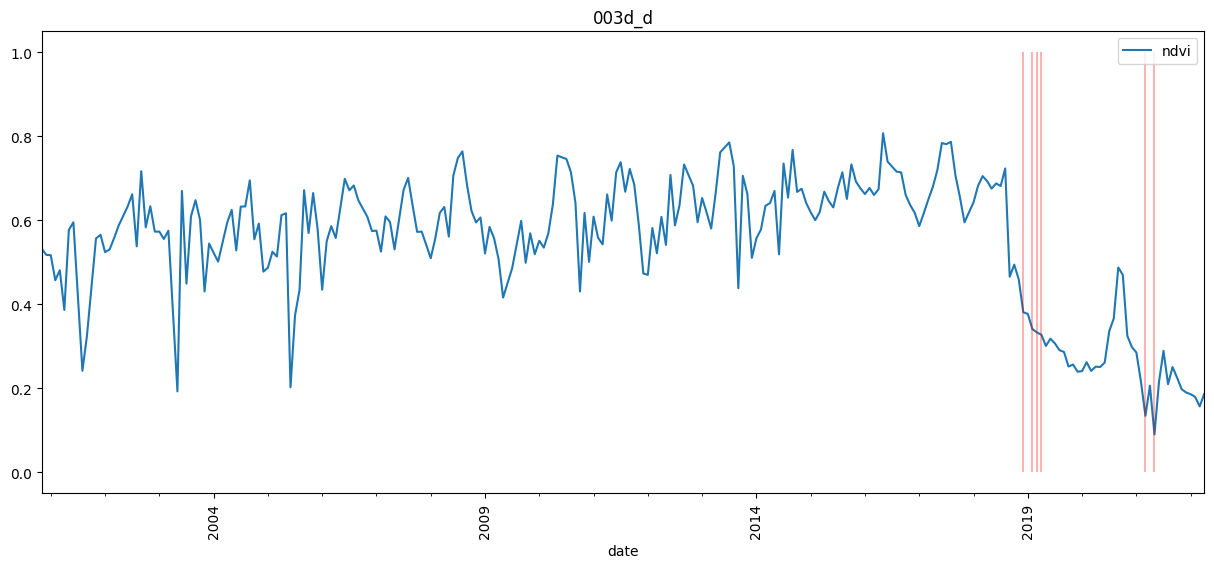

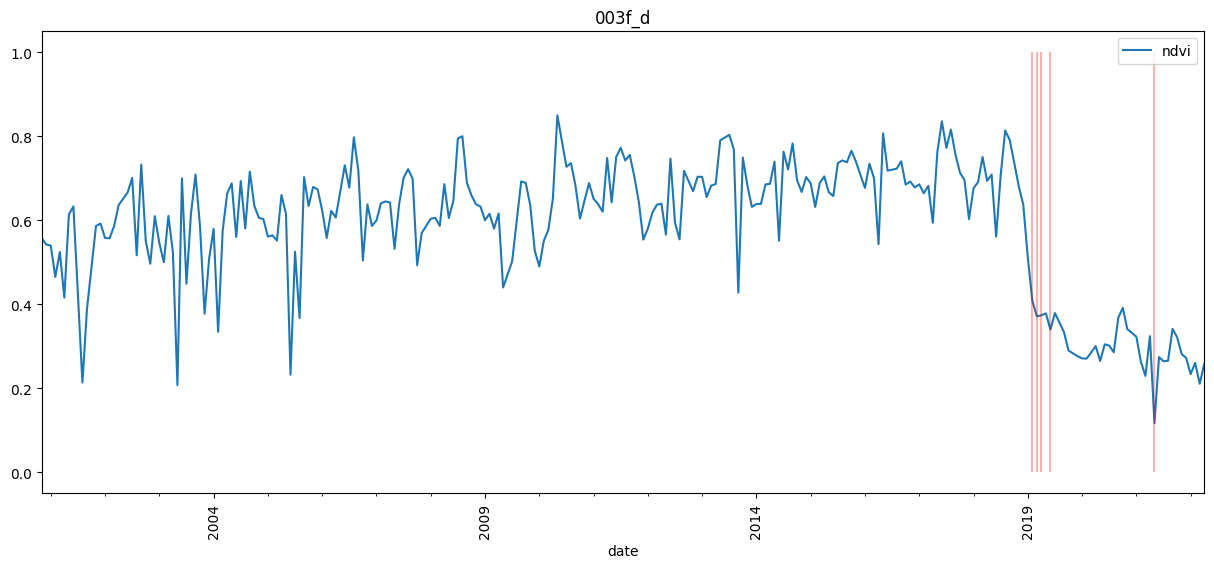

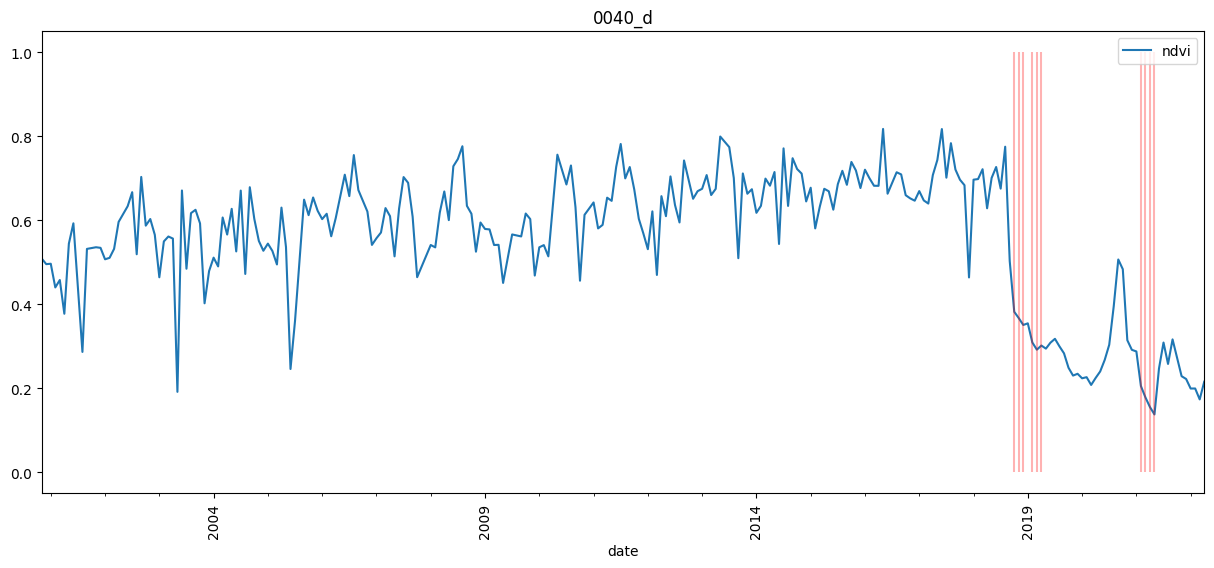

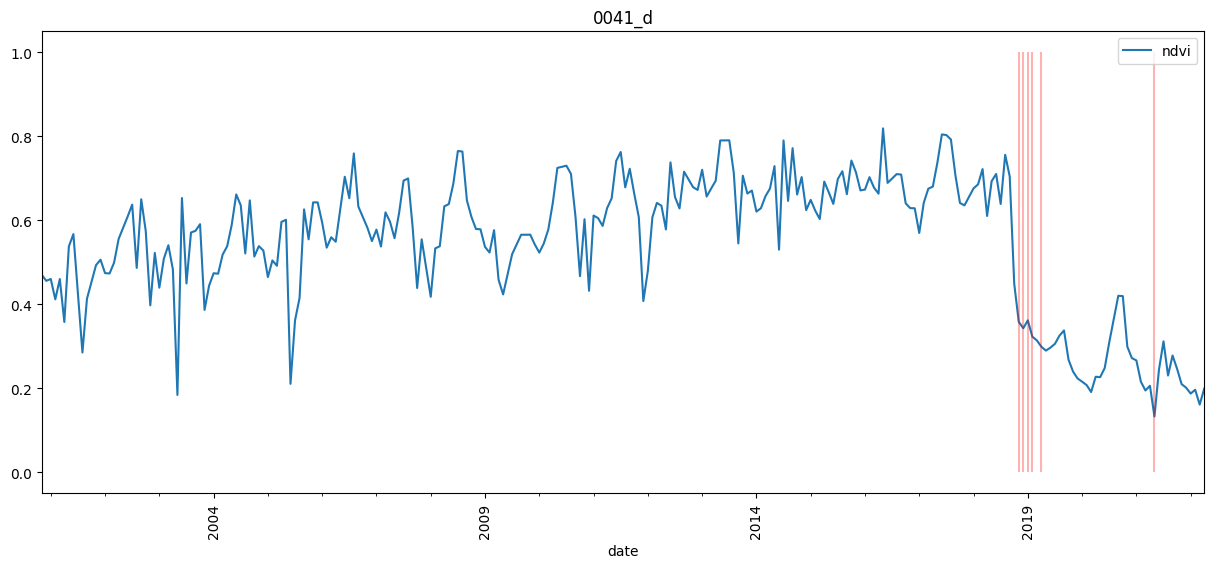

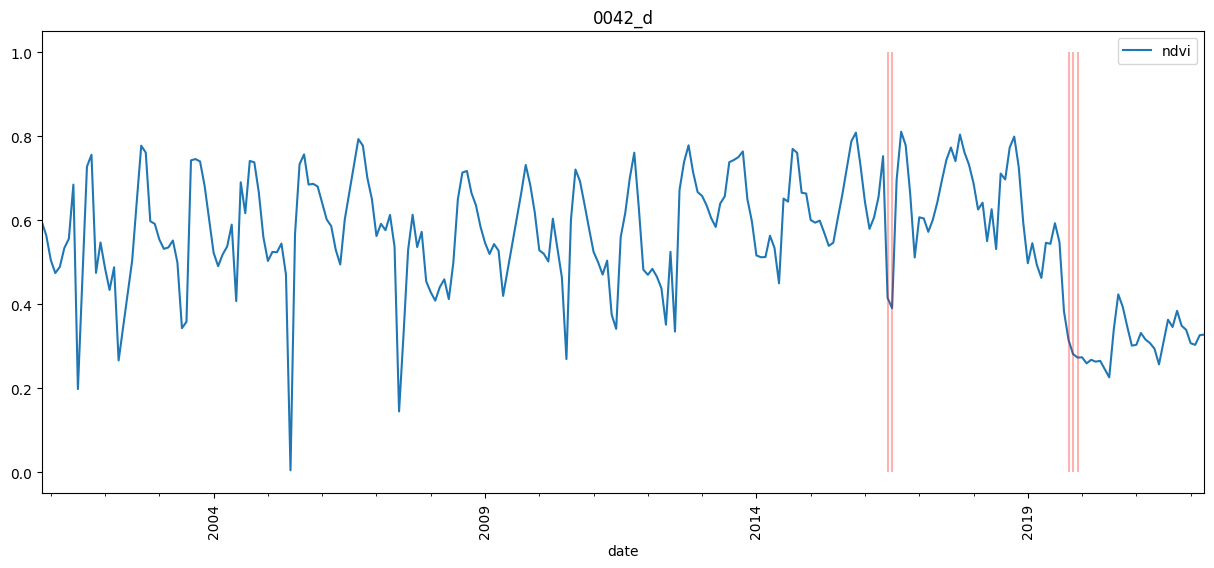

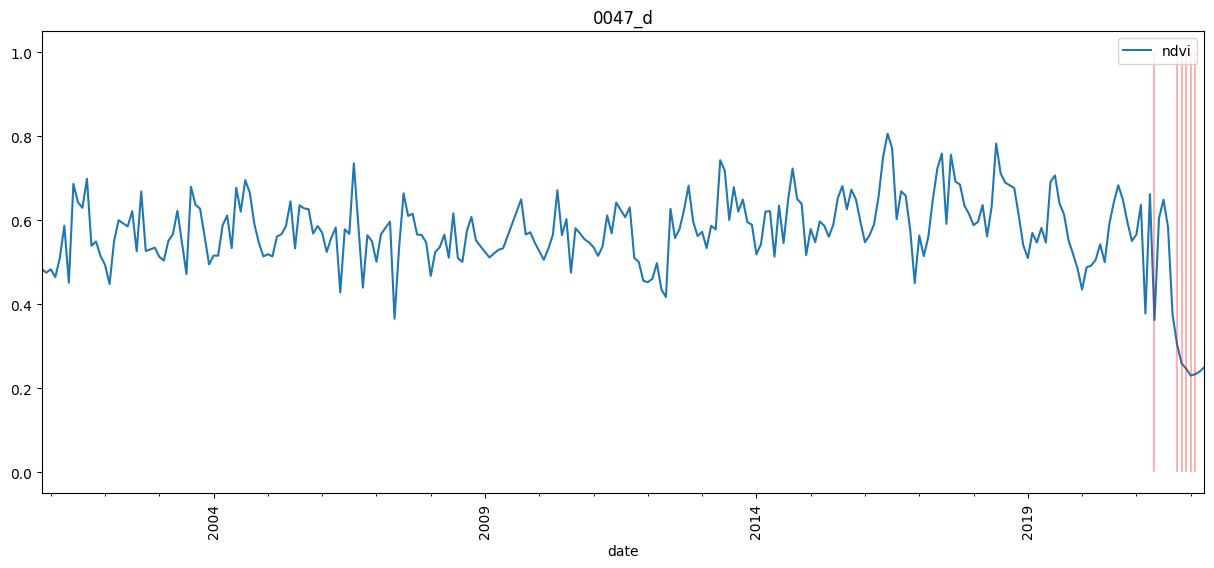

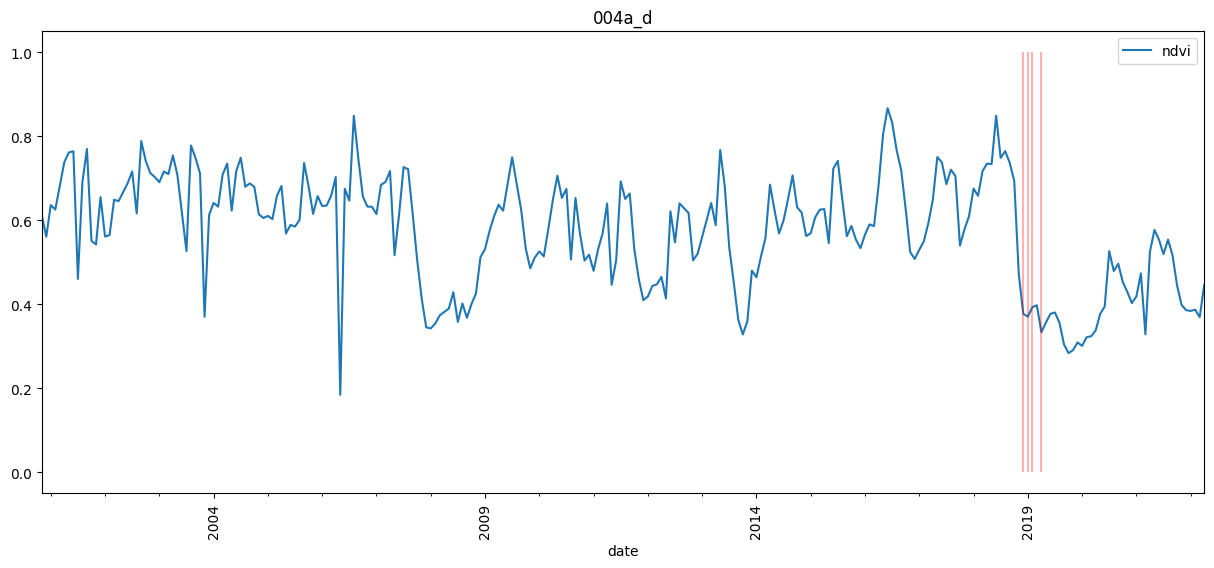

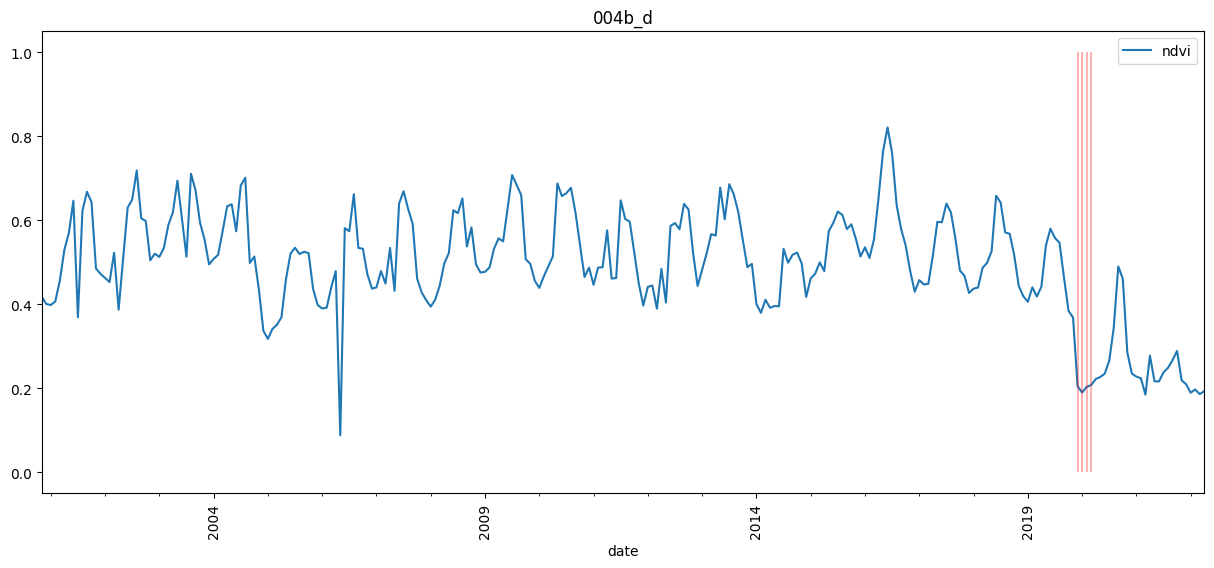

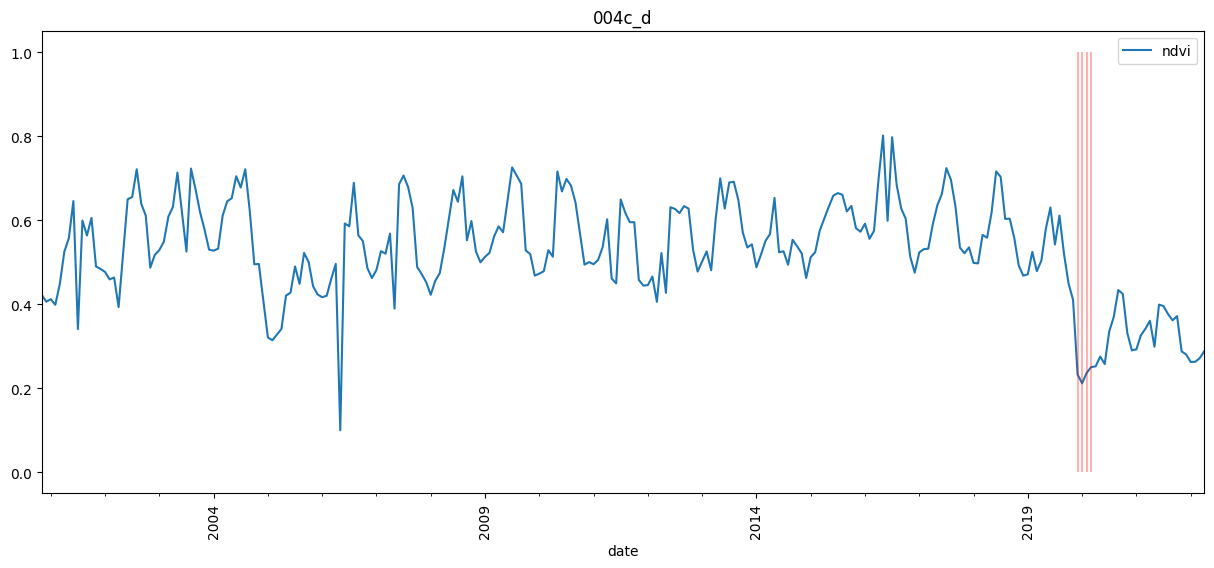

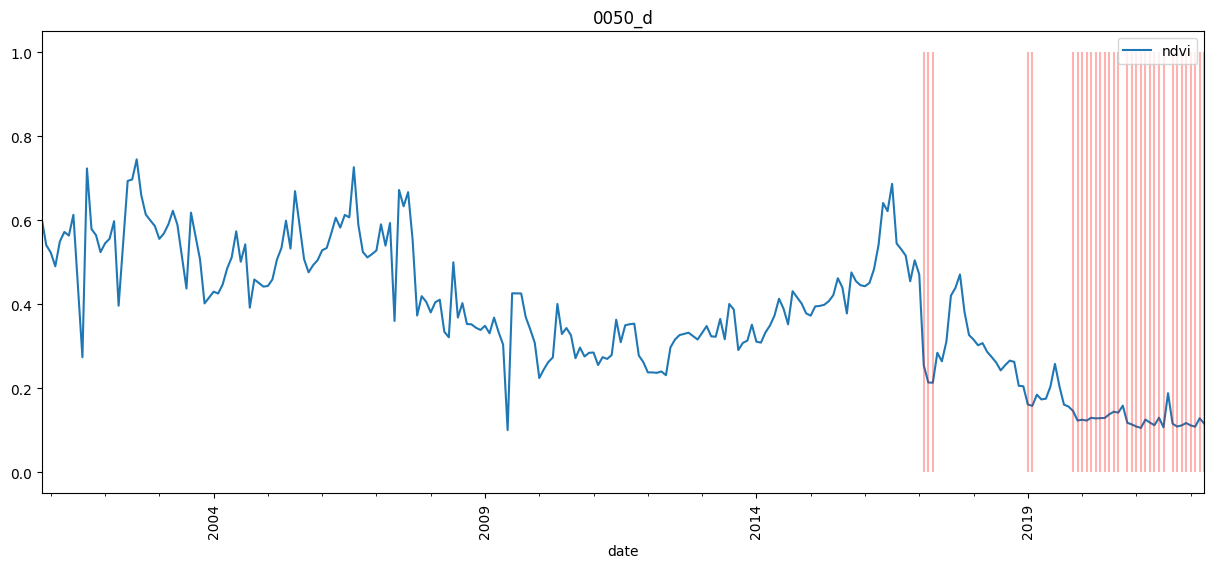

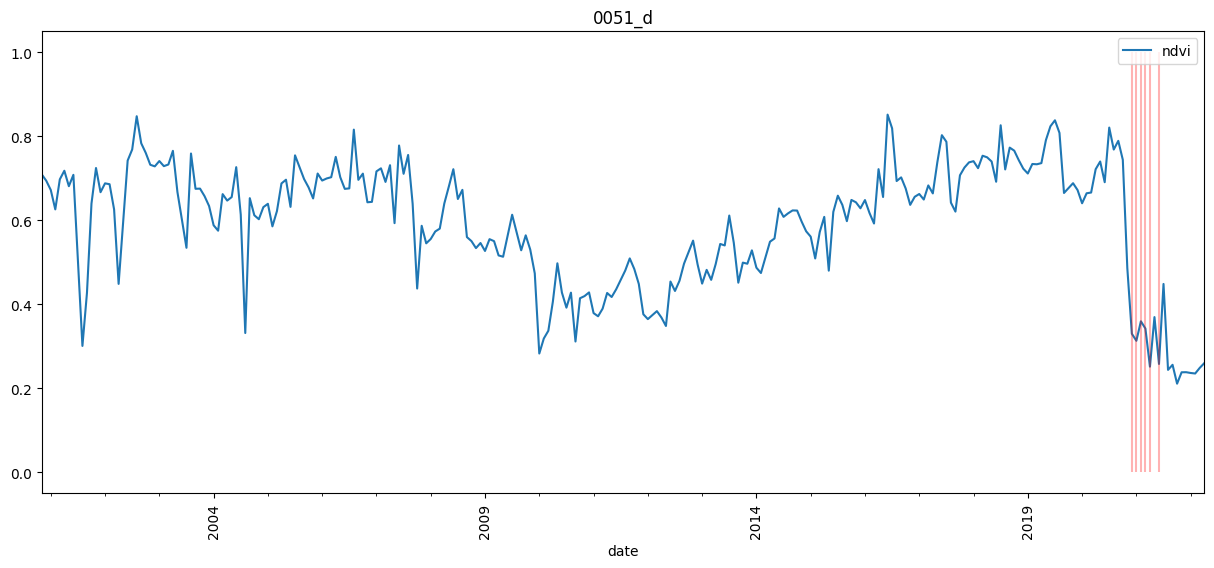

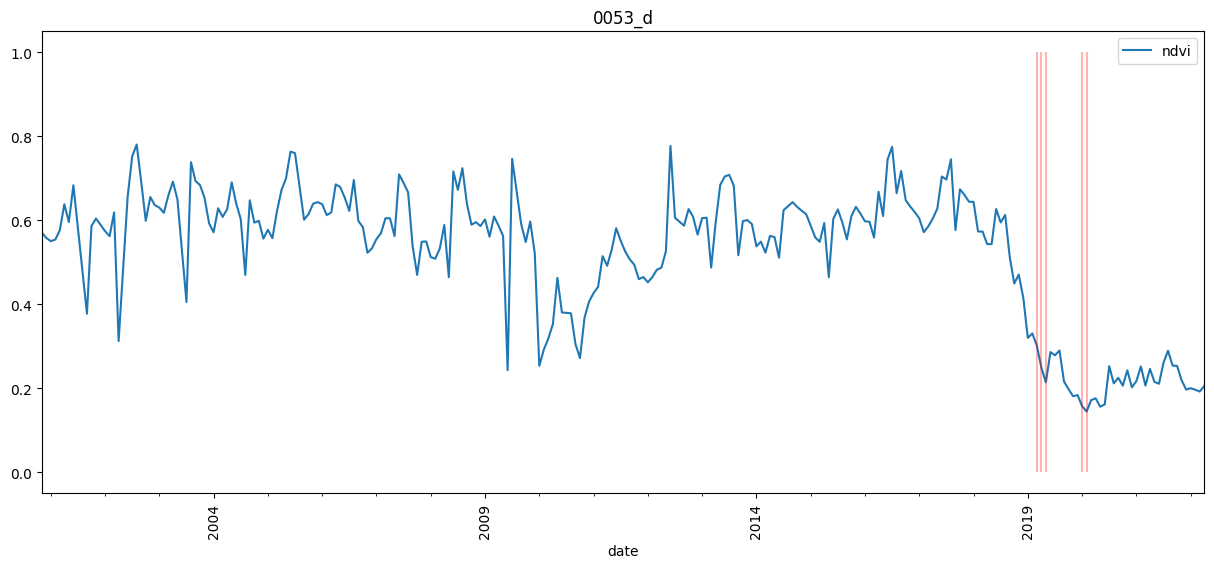

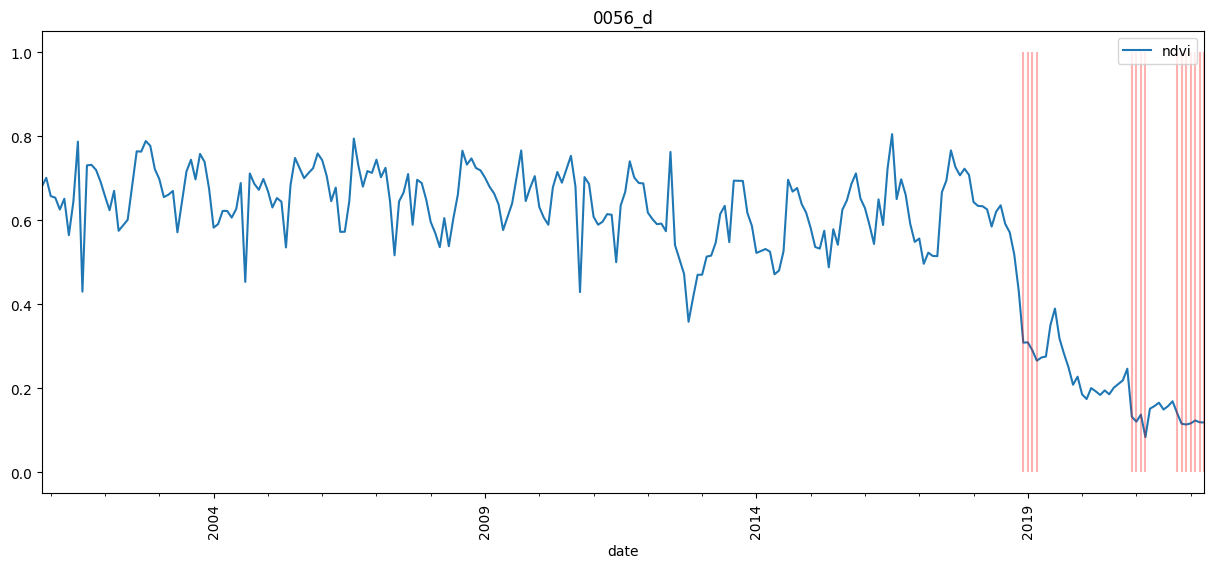

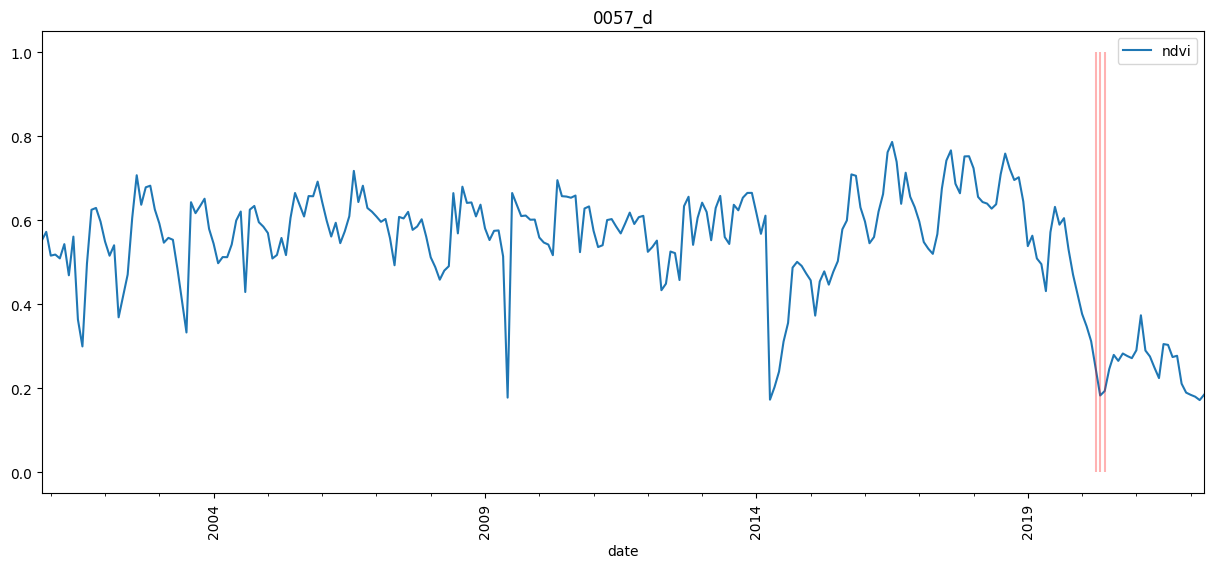

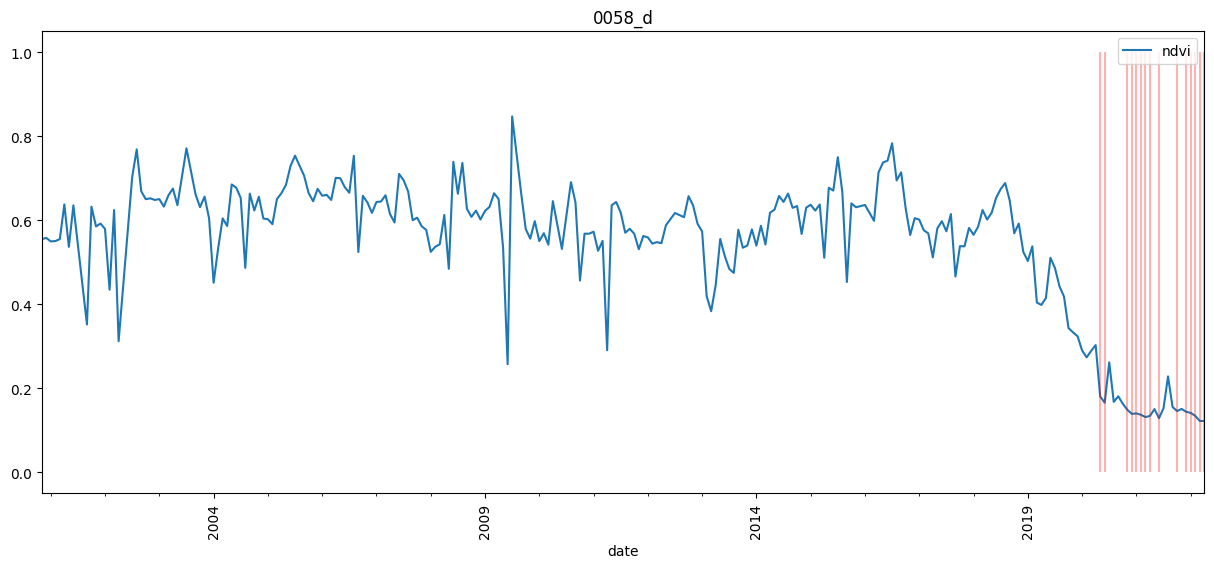

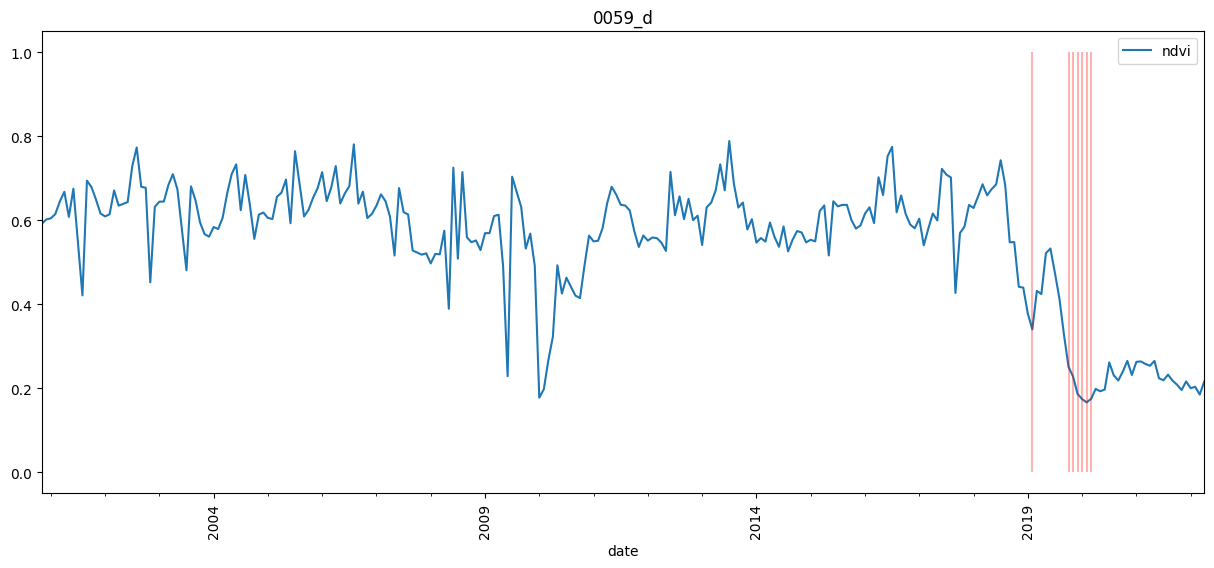

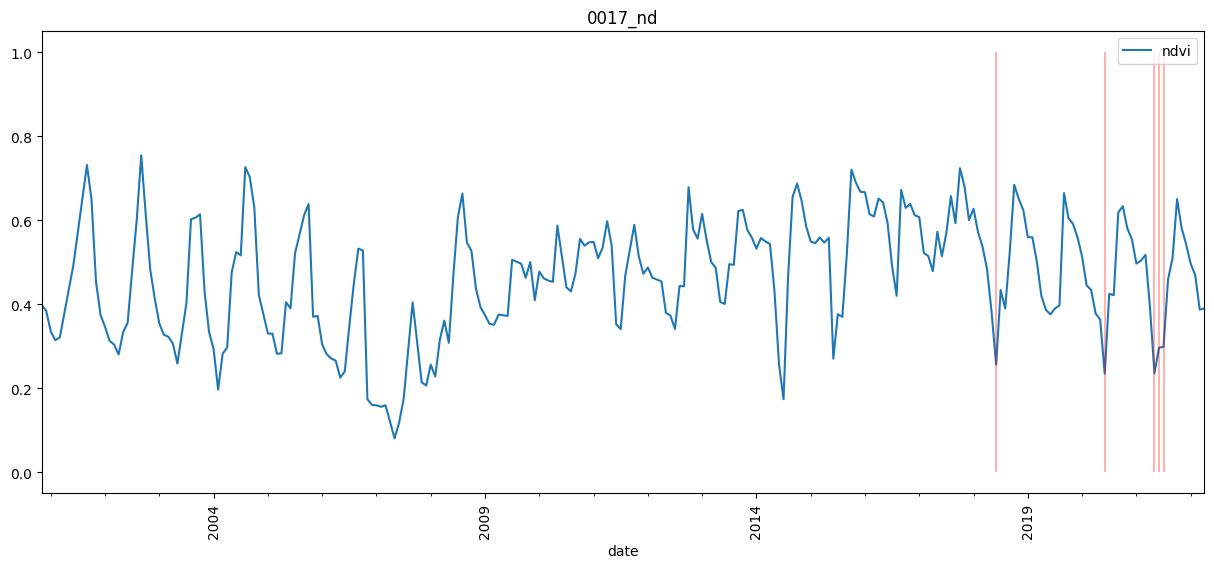

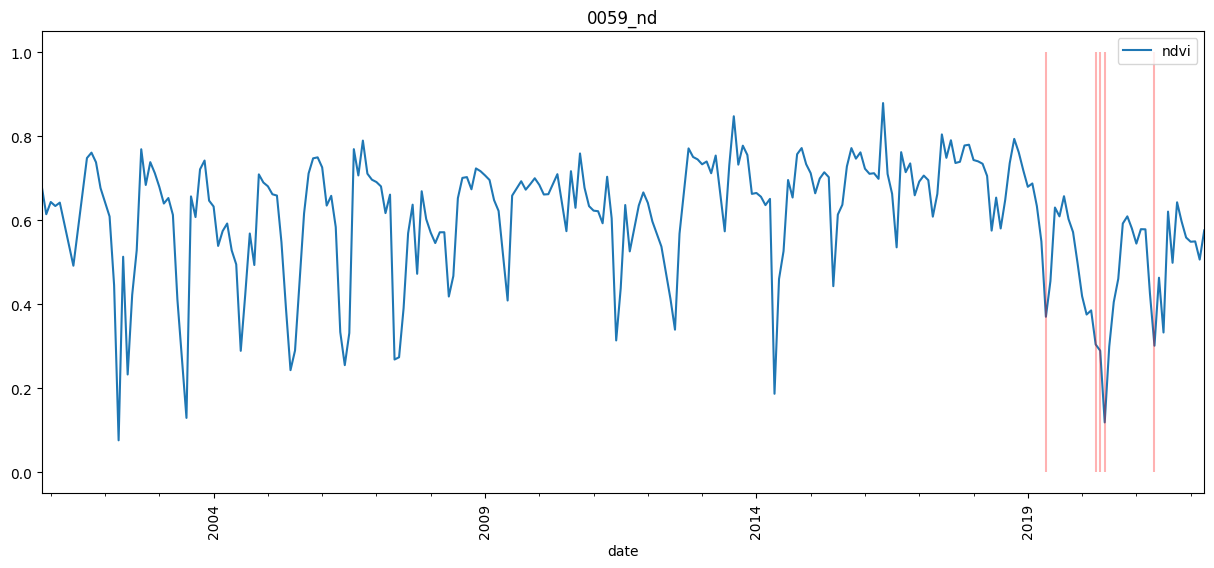

In [130]:
for ide in findings.ts_id.unique():
    plot_anomalies(ide)    